## Core Idea

Geometry and pattern matching approach to predict scaler coupling constant.

The hypothesis of this kernel:
1. If we have two similar sets of atoms with the same distances between them and the same coupling types - the scalar coupling constant should be very close.
2. Closer atoms to the pair of atoms under prediction have higher influence on scalar coupling constant then those with further away.

Each atom is described with 3 cartesian coordinates. One problem is that each coupling pair is located in a different point in space and two similar coupling sets would have very different X,Y,Z.

So, instead of using coordinates, let's consider next system:
1. Take each pair of atoms as two first core atoms
2. Calculate the center between the pair
3. Find all n-nearest atoms to the center (excluding first two atoms)
4. Take two closest atoms from step 3 - they will be 3rd and 4th core atoms
5. Calculate the distances from 4 core atoms to the rest of the atoms and to the core atoms as well

Using this representation each atom position can be described by 4 distances from the core atoms. This representation is stable to rotation and translation. And it's suitable for pattern-matching. So, we can take a sequence of atoms, describe each by 4 distances + atom type(H,O,etc) and looking up for the same pattern we can find similar configurations and detect scalar coupling constant.

In [103]:
# predict_scalar_coupling_approach.gif

from IPython.display import Image
Image(url='predicting_scalar_coupling_approach.gif')  

# Magnitude of J-coupling
For 1H–1H coupling, the magnitude of J provides information on the proximity of the coupling partners. Generally speaking 2-bond coupling (i.e. 1H–C–1H) is stronger than three-bond coupling (1H–C–C–1H). The magnitude of the coupling also provides information on the dihedral angles relating the coupling partners, as described by the Karplus relationship.

## why 1JHC for methane is 84.80-ish?
I think it's because these structures are the result of a QM simulation at 0 K, so it doesn't reflect reality at higher temperatures, or include dynamics.
Experimentally the 1JHC coupling: https://www.sciencedirect.com/science/article/pii/0022236491900755)
The bond lengths: http://www.colby.edu/chemistry/webmo/CH4.html

## Load Everything

In [65]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np


from sklearn.model_selection import KFold,train_test_split
# KFold: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

from sklearn.metrics import mean_absolute_error

import seaborn as sns

from lightgbm import LGBMRegressor

In [66]:
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [67]:
# pd.set_option(): https://www.tutorialspoint.com/python_pandas/python_pandas_options_and_customization.htm
# Options and Customization
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

/Users/Koitaro/Desktop/PMP_distance/PMP_distance/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


## Load Dataset

By default all data is read as `float64` and `int64`. We can trade this uneeded precision for memory and higher prediction speed. So, let's read with Pandas all the data in the minimal representation: https://datacarpentry.org/python-ecology-lesson/04-data-types-and-format/

In [68]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_csv = pd.read_csv('train.csv', index_col='id', dtype=train_dtypes)
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
print(train_csv.head(25))





/Users/Koitaro/Desktop/PMP_distance/PMP_distance/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


    molecule_index  atom_index_0  atom_index_1  type  scalar_coupling_constant
id                                                                            
0   1               1             0             1JHC  84.807602               
1   1               1             2             2JHH -11.257000               
2   1               1             3             2JHH -11.254800               
3   1               1             4             2JHH -11.254300               
4   1               2             0             1JHC  84.807404               
5   1               2             3             2JHH -11.254100               
6   1               2             4             2JHH -11.254800               
7   1               3             0             1JHC  84.809303               
8   1               3             4             2JHH -11.254300               
9   1               4             0             1JHC  84.809502               
10  2               1             0             1JHN

In [69]:
print('Shape: ', train_csv.shape)
print('Total: ', train_csv.memory_usage().sum())
train_csv.memory_usage()
print('Total # of molecules in train.csv: ', len(train_csv['molecule_index'].unique()))

Shape:  (4659076, 5)
Total:  88522828
Total # of molecules in train.csv:  85012


In [70]:
output_result_csv = pd.read_csv('sample_output_result.csv', index_col='id')

/Users/Koitaro/Desktop/PMP_distance/PMP_distance/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [71]:
test_csv = pd.read_csv('test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]
test_csv.head(25)

molecule_index  atom_index_0  atom_index_1  type
id                                                       
4659076  4               2             0             2JHC
4659077  4               2             1             1JHC
4659078  4               2             3             3JHH
4659079  4               3             0             1JHC
4659080  4               3             1             2JHC
4659081  14              3             0             1JHC
4659082  14              3             1             2JHC
4659083  14              3             4             2JHH
4659084  14              3             5             2JHH
4659085  14              3             6             3JHH
4659086  14              3             7             3JHH
4659087  14              4             0             1JHC
4659088  14              4             1             2JHC
4659089  14              4             5             2JHH
4659090  14              4             6             3JHH
4659091  14              4             7             3JHH
4659092  14              5             0             1JHC
4659093  14              5             1             2JHC
4659094  14              5             6             3JHH
4659095  14              5             7             3JHH
4659096  14              6             0             2JHC
4659097  14              6             1             1JHC
4659098  14              6             7             2JHH
4659099  14              6             8             3JHH
4659100  14              7             0             2JHC

In [72]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_csv = pd.read_csv('structures.csv', dtype=structures_dtypes)
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
print(structures_csv.head(50))
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
print(structures_csv.head(50))



    molecule_index  atom_index atom         x         y         z
0   1               0           C   -0.012698  1.085804  0.008001
1   1               1           H    0.002150 -0.006031  0.001976
2   1               2           H    1.011731  1.463751  0.000277
3   1               3           H   -0.540815  1.447527 -0.876644
4   1               4           H   -0.523814  1.437933  0.906397
5   2               0           N   -0.040426  1.024108  0.062564
6   2               1           H    0.017257  0.012545 -0.027377
7   2               2           H    0.915789  1.358745 -0.028758
8   2               3           H   -0.520278  1.343532 -0.775543
9   3               0           O   -0.034360  0.977540  0.007602
10  3               1           H    0.064766  0.020572  0.001535
11  3               2           H    0.871790  1.300792  0.000693
12  4               0           C    0.599540  0.000000  1.000000
13  4               1           C   -0.599540  0.000000  1.000000
14  4     

In [73]:
print('Shape: ', structures_csv.shape)
print('Total: ', structures_csv.memory_usage().sum())
print(structures_csv.memory_usage())
print('Total # of molecules: ', len(structures_csv['molecule_index'].unique()))

Shape:  (2358875, 6)
Total:  42459878
Index             128    
molecule_index    9435500
atom_index        2358875
atom              2358875
x                 9435500
y                 9435500
z                 9435500
dtype: int64
Total # of molecules:  130789


## Build Distance Dataset

In [74]:
# drop(axis=0/1): https://stackoverflow.com/questions/22149584/what-does-axis-in-pandas-mean

def build_type_dataframes(base, structures, coupling_type):
    
    # from base dataframe, select rows that have the specified coupling_type, and then drop the column of that type
    # then make copy
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    
    # reset id
    base = base.reset_index()
    
    # set data type for the newly created id column
    base['id'] = base['id'].astype('int32')
    
    # select molecule structures that match molecule_index in base dataframe file
    # Note that molecule_name in the oririnal file were converted into molecule_index in the new dataframe
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    
    # return base dataframe and structure dataframe that only have rows with the specified coupling type
    return base, structures

In [75]:
# merge example: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html

# df1 = pd.DataFrame({'lkey': ['foo', 'bar', 'baz', 'foo'],
#                     'value_1': [1, 2, 3, 5]})
# df2 = pd.DataFrame({'rkey': ['foo', 'bar', 'baz', 'foo'],
#                     'value_2': [5, 6, 7, 8]})
# print(df1)
# print(df2)
# print(df1.merge(df2, left_on='lkey', right_on='rkey'))
# print(df1.merge(df2, left_on=['lkey','value_1'], right_on=['rkey','value_2']).drop(['value_2'],axis=1))

In [76]:
def add_coordinates(base, structures, index):
    
    # select rows from both base dataframe and structure dataframe
    # such that moleucle_index and atom_index both match.
    # Basically this function is choosing every atom with specified coupling type from base dataframe,
    # then, also select coresponding coordinates from structures dataframe.
    # For example, 3 H atoms in ammonia molecule from base dataframe
    # then select coordinates from structures dataframe
    # In ammonia case, I need to add coordinates for Hydrogen and Nitrogen, so I need to do this
    # with atom_index_0 and atom_index_1
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    
    # rename columns for structure dataframe part after merging
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [77]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [78]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    # select and merge all rows that have the same molecule_index
    # At this point, putting all 1JHN molecules for each x_c, y_c, z_c
    # so I need to drop atoms that make center atoms
    # For ammonia case, now I have 12 rows. I have 3 atom centers. For each center, I have 4 xyz coordinates.
    # But I need to drop rows with coordinates that form centers.
    
    # drop rows that have atoms to make centers.
    # Now, I have 2 atoms for each center.
    # For ammonia case, for a center between atom_index_1=0 (Nitrogen) and atom_index_0=0 (Hydrogen)
    # This center has atom_index = 2 and 3
    # Other 2 centers follow the same way, so total 6 rows.
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [79]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

# Euclidean distance
def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

# calculate all distance among atoms
# d_1_0 to d_9_1, around core atoms to far atoms. But, limit the total # of distances to be calculated,
# assuming that far atoms have less and less influence to scalar coupling of core atoms.
def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [80]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

# test
# col_list = ['molecule_index', 'atom_index_0', 'atom_index_1', 'atom_2', 'atom_3',
#        'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9', 'x_2',
#        'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'y_2', 'y_3', 'y_4',
#        'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6',
#        'z_7', 'z_8', 'z_9']

# n_atoms = 1 + max([int(c.split('_')[1]) for c in col_list if c.startswith('x_')])
# print(n_atoms)
# output is 10

# test
# for i in range(1,10):
#         for vi in range(min(4, i)):
#             print(i, vi)
# output
# 1 0
# 2 0
# 2 1
# 3 0
# 3 1
# 3 2
# 4 0
# 4 1
# 4 2
# 4 3
# 5 0
# 5 1
# 5 2
# 5 3
# 6 0
# 6 1
# 6 2
# 6 3
# 7 0
# 7 1
# 7 2
# 7 3
# 8 0
# 8 1
# 8 2
# 8 3
# 9 0
# 9 1
# 9 2
# 9 3


In [81]:
# Looks like this function was not used

# def add_n_atoms(base, structures):
#     dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
#     return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

In [82]:
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    
    # build_type_dataframes()
    # return base dataframe and structure dataframe that only have rows with the specified coupling type
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    
    # add_coordinates()
    # add all coordinates of atoms in atom_index_0, all 3 Hydrogen atoms in ammonia case 
    base = add_coordinates(base, structures, 0)
    # add all cordinates of coresponsing atoms in atom_index_1, Nitrogen atom for each Hydrogen in ammonia case
    base = add_coordinates(base, structures, 1)
    
    # drop atom_0 column (H in this case) and atom_1 column (N in this case)
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    
    # drop id column
    atoms = base.drop('id', axis=1).copy()
    
    # drop scalar_coupling_constant column, but why???
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
    
    # calculate all coordinates between all Hydrogen and Nitrogen
    # in ammonia case for example and store as x_c, y_c, and z_c
    add_center(atoms)
    
    # drop x_0 to z_1 columns since I have x_c, y_c, z_c
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)
    
    # merge_all_atoms()
    # To have coordinates of centers (x_c, y_c, z_c) and non-core atoms for each center
    atoms = merge_all_atoms(atoms, structures)
    
    # calculate the distance between centers and all non-core atoms, then store it in d_c column
    # Euclidean distance
    add_distance_to_center(atoms)
    
    # Now I have distances, so drop centers and atom_index
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    
    # sorting distances with one atom center, and then sorting distances with another atom center, and so forth
    # Note: inplace means the existing data is modified, and without inplace, the existing data is copied to 
    # another place and some action is performed on the new data. So the existing data is preserved.
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    
    # groupby: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html
    # Need to use groupby Probably to cumcount # of atoms
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    
    # cumcount: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.GroupBy.cumcount.html
    atoms['num'] = atom_groups.cumcount() + 2
    
    # atoms dataframe are already sorted by distance, so d_c column is not necessary now
    atoms = atoms.drop(['d_c'], axis=1)
    # print(atoms[80:180])
    
    # In case of molecule 76, for example, from the center between core Hydrogen and core Nitrogen,
    # there are total 10 distances. By setting n_atoms = 10 as default,
    # the two rows with farthest distances are dropped. 
    atoms = atoms[atoms['num'] < n_atoms]
    # print(atoms[80:180])
    # print(atoms.head(14))
    
    # unstack(): https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html
    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    # print(atoms.head(10))
    # print(atoms.columns)
    
    # changing column names
    # Note: because 'molecule_index', 'atom_index_0', 'atom_index_1', 'num' are set to index,
    # they don't appear in atoms.columns
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    # print(atoms.head(10))
    
    # reset index, now all column names appear by atoms.columns
    atoms = atoms.reset_index()
    # print(atoms.columns)
    
    # downcast back to int8, setting data types
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    # lengths of base dataframe and atoms dataframe are the same: 43680
    # merge columns from base dataframe:
    # ['id', 'molecule_index', 'atom_index_0', 'atom_index_1','scalar_coupling_constant',
    # 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1']
    # merge columns from atoms dataframe:
    # ['molecule_index', 'atom_index_0', 'atom_index_1',
    # 'atom_2', 'atom_3','atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9', 'x_2',
    # 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'y_2', 'y_3', 'y_4',
    # 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6',
    # 'z_7', 'z_8', 'z_9']
    # to form columns in full dataframe:
    # ['id', 'molecule_index', 'atom_index_0', 'atom_index_1','scalar_coupling_constant',
    # 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1',
    # 'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
    # 'atom_9', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'y_2',
    # 'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'z_2', 'z_3', 'z_4',
    # 'z_5', 'z_6', 'z_7', 'z_8', 'z_9']
    full = add_atoms(base, atoms)
    
    # add_distances()
    # calculate distances around core atoms and store them in d_x_x columns
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

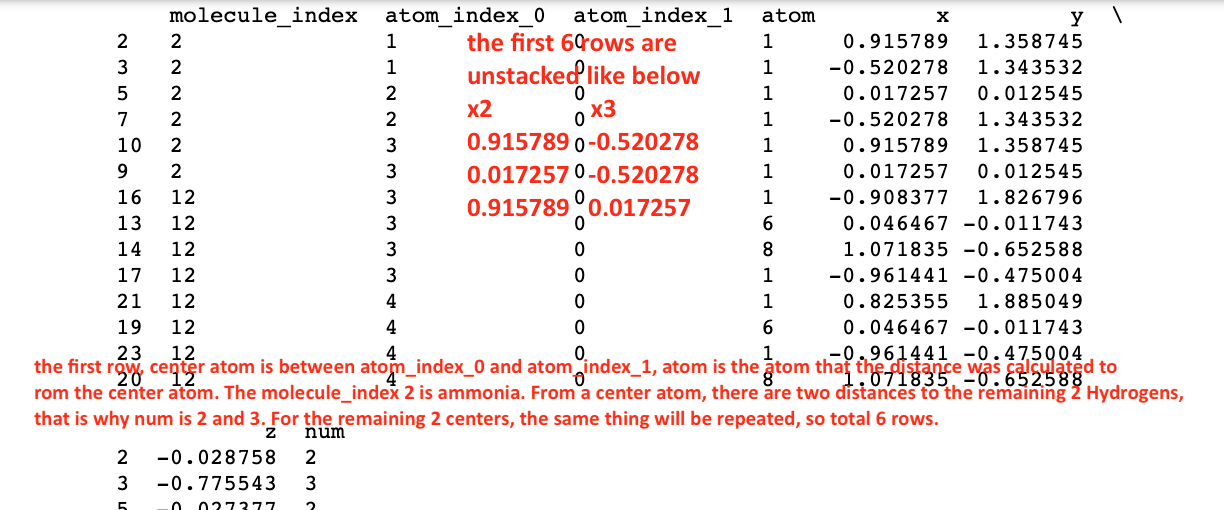

In [83]:
from IPython.display import Image
Image(filename='before_index_unstack.png')

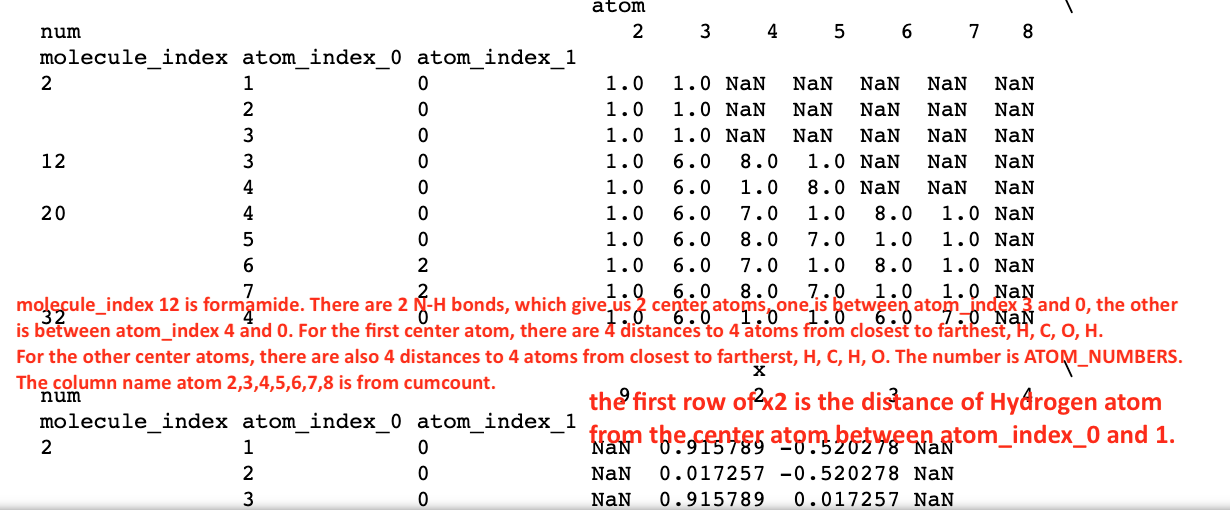

In [84]:
Image(filename='after_index_unstack.png')

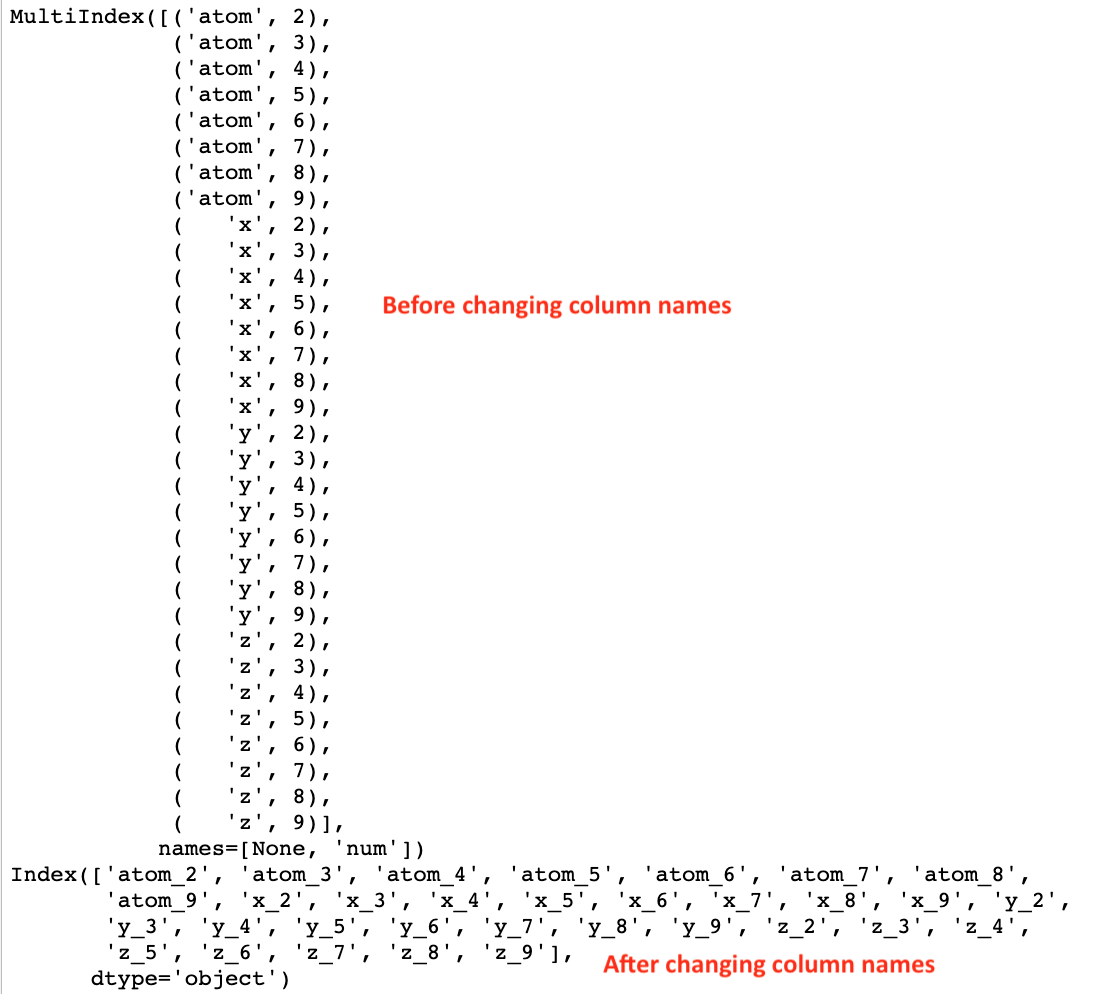

In [85]:
Image(filename='before_after_changing_column_names.png')

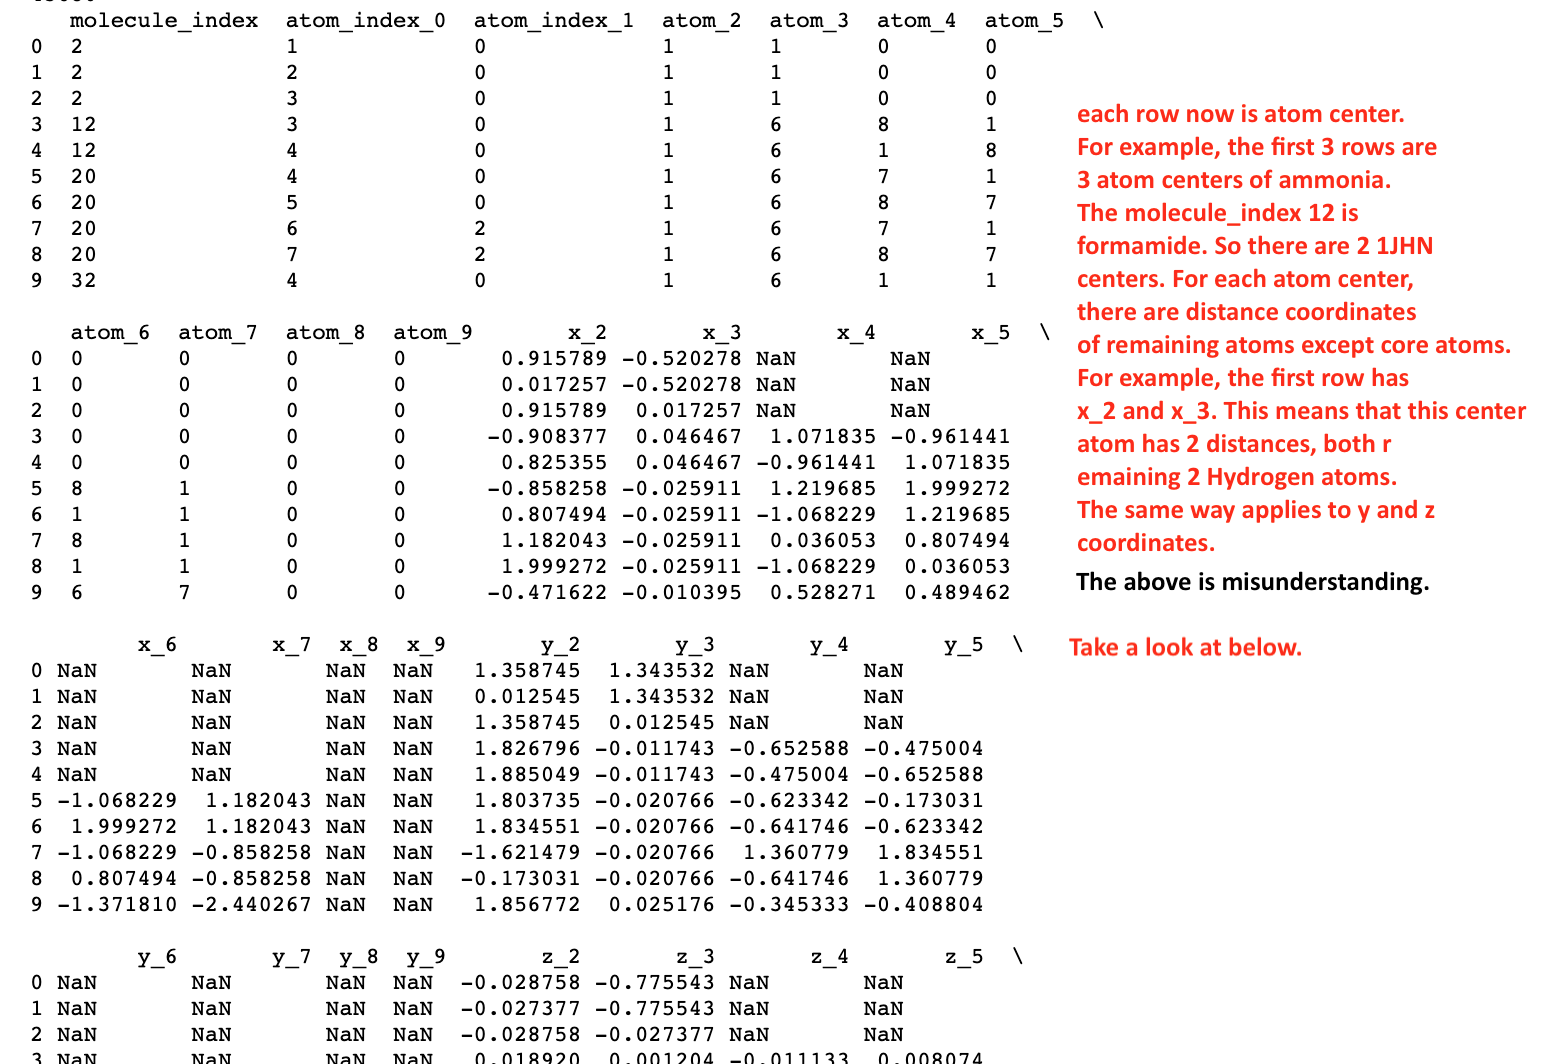

In [86]:
Image(filename='after_changing_column_names.png')

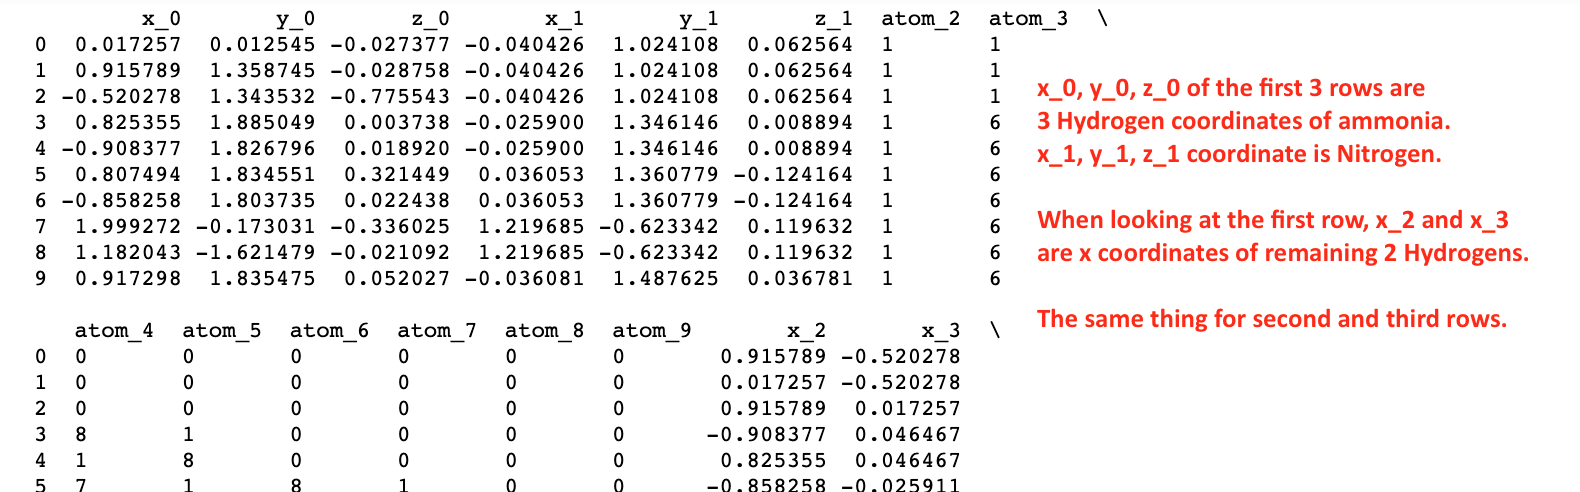

In [87]:
Image(filename='after_add_distances.png')

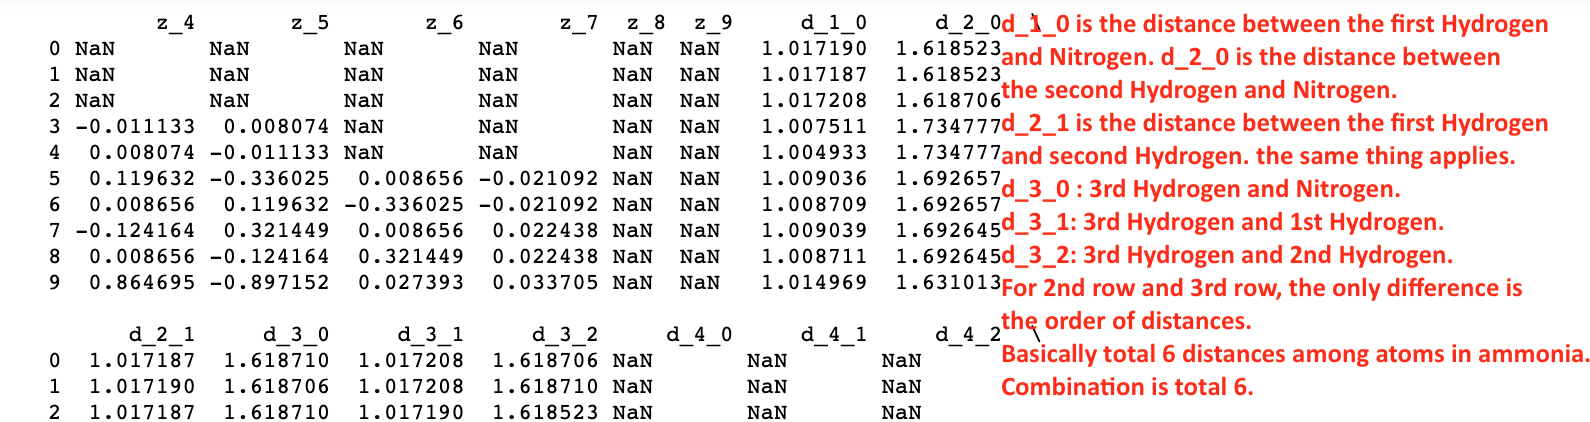

In [88]:
Image(filename='after_add_distances_2.png')

In [89]:
# conditional statements: <expr1> if <conditional_expr> else <expr2>
# https://realpython.com/python-conditional-statements/

def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    return df[labels]

## experiment LightGBM model with the smallest dataset

In [90]:
%%time
full = build_couple_dataframe(train_csv, structures_csv, '1JHN', n_atoms=10)
print(full.shape)

(43680, 73)
CPU times: user 1.36 s, sys: 371 ms, total: 1.73 s
Wall time: 1.74 s


In [91]:
print(full.columns)
print(len(full))
# print(full.head(10))
# In full dataframe, the scalar coupling in each row is the scalar coupling of core atoms (I guess)

Index(['id', 'molecule_index', 'atom_index_0', 'atom_index_1',
       'scalar_coupling_constant', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1',
       'atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'y_2',
       'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'z_2', 'z_3', 'z_4',
       'z_5', 'z_6', 'z_7', 'z_8', 'z_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0',
       'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1',
       'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1',
       'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1',
       'd_9_2', 'd_9_3'],
      dtype='object')
43680


For experiments, full dataset can be built with higher number of atoms, and for building a training/validation sets we can trim them:

In [92]:
df = take_n_atoms(full, 7)
# LightGBM performs better with 0-s then with NaN-s
df = df.fillna(0)
print(df.columns)
print(df.head(3))
print(len(df))

Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')
   atom_2  atom_3  atom_4  atom_5  atom_6     d_1_0     d_2_0     d_2_1  \
0  1       1       0       0       0       1.017190  1.618523  1.017187   
1  1       1       0       0       0       1.017187  1.618523  1.017190   
2  1       1       0       0       0       1.017208  1.618706  1.017187   

      d_3_0     d_3_1     d_3_2  d_4_0  d_4_1  d_4_2  d_4_3  d_5_0  d_5_1  \
0  1.618710  1.017208  1.618706  0.0    0.0    0.0    0.0    0.0    0.0     
1  1.618706  1.017208  1.618710  0.0    0.0    0.0    0.0    0.0    0.0     
2  1.618710  1.017190  1.618523  0.0    0.0    0.0    0.0    0.0    0.0     

   d_5_2  d_5_3  d_6_0  d_6_1  d_6_2  d_6_3  scalar_coupling_constant  
0  0.0    0.0    0.0    0.0

In [93]:
X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
y_data = df['scalar_coupling_constant'].values.astype('float32')
print("X_train (ammonia): \n{}\n\n".format(X_data[:3]))
print("y_train (ammonia): \n{}\n\n".format(y_data[:3]))


X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=128)
X_train.shape, X_val.shape, y_train.shape, y_val.shape
print(f'X_train: \n{X_train[:4]}\n\n',f'X_val: \n{X_val[:4]}\n\n',f'y_train: \n{y_train[:4]}\n\n',f'y_val: \n{y_val[:4]}\n\n')


X_train (ammonia): 
[[1.        1.        0.        0.        0.        1.01719   1.6185228
  1.0171872 1.6187098 1.0172079 1.6187056 0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.       ]
 [1.        1.        0.        0.        0.        1.0171872 1.6185228
  1.01719   1.6187056 1.0172079 1.6187098 0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.       ]
 [1.        1.        0.        0.        0.        1.0172079 1.6187056
  1.0171872 1.6187098 1.01719   1.6185228 0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.       ]]


y_train (ammonia): 
[32.6889 32.6891 32.6905]


X_train: 
[[1.        6.        1.        1.        1.        1.013774  1.6275383
  1.0160719 2.0463681 1.4627149 2.047436  2.3050725 2.0909886 2.9278572
  1.0950602 2.5641537 2.1729996 2.3942215 1.0960515 3.2997756 2.4843767
  2.9675806 2.6519005]
 [1. 

In [94]:
# configuration params are copied from @artgor kernel:
# https://www.kaggle.com/artgor/brute-force-feature-engineering

# LightGBM: parameters
# https://lightgbm.readthedocs.io/en/latest/Parameters.html#learning-control-parameters

LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'num_leaves': 128,
    'min_child_samples': 79,
    'max_depth': 9,
    'subsample_freq': 1,
    'subsample': 0.9,
    'bagging_seed': 11,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0
}

# objective (string, callable or None, optional (default=None)) – Specify the learning task and the 
# corresponding learning objective or a custom objective function to be used (see note below).
# Default: ‘regression’ for LGBMRegressor, ‘binary’ or ‘multiclass’ for LGBMClassifier,
# ‘lambdarank’ for LGBMRanker.

# metric: mae, mean_absolute_error

# verbosity: an option for producing detailed logging information. Be aware, and will probably notice
# if you enable verbose > 0, that printing to the screen is generally a very slow process.
# The algorithm may run an order of magnitude slower, or more, with verbose enabled.

# boosting_type: 'gbdt': traditional Gradient Boosting Decision Tree, aliases: gbrt

# num_leaves: max number of leaves in one tree

# min_data_in_leaf, default = 20, type = int, aliases: min_data_per_leaf, min_data, min_child_samples,
# constraints: min_data_in_leaf >= 0
# minimal number of data in one leaf. Can be used to deal with over-fitting

# max_depth, default = -1, type = int
# limit the max depth for tree model. This is used to deal with over-fitting when #data is small.
# Tree still grows leaf-wise
# <= 0 means no limit

# bagging_freq, default = 0, type = int, aliases: subsample_freq
# frequency for bagging
# 0 means disable bagging; k means perform bagging at every k iteration
# Note: to enable bagging, bagging_fraction should be set to value smaller than 1.0 as well

# bagging_fraction, default = 1.0, type = double, aliases: sub_row, subsample, bagging,
# constraints: 0.0 < bagging_fraction <= 1.0
# like feature_fraction, but this will randomly select part of data without resampling
# can be used to speed up training
# can be used to deal with over-fitting
# Note: to enable bagging, bagging_freq should be set to a non zero value as well

# bagging_seed, default = 3, type = int, aliases: bagging_fraction_seed
# random seed for bagging

# lambda_l1, default = 0.0, type = double, aliases: reg_alpha, constraints: lambda_l1 >= 0.0
# L1 regularization

# lambda_l2, default = 0.0, type = double, aliases: reg_lambda, lambda, constraints: lambda_l2 >= 0.0
# L2 regularization

# feature_fraction, default = 1.0, type = double, aliases: sub_feature, colsample_bytree,
# constraints: 0.0 < feature_fraction <= 1.0
# LightGBM will randomly select part of features on each iteration (tree)
# if feature_fraction smaller than 1.0. For example, if you set it to 0.8, LightGBM will select 80% of features
# before training each tree
# can be used to speed up training
# can be used to deal with over-fitting

# num_iterations, default = 100, type = int, aliases: num_iteration, n_iter, num_tree, num_trees,
# num_round, num_rounds, num_boost_round, n_estimators, constraints: num_iterations >= 0
# number of boosting iterations
# Note: internally, LightGBM constructs num_class * num_iterations trees for multi-class classification problems

# n_jobs: num_threads, default = 0, type = int, aliases: num_thread, nthread, nthreads, n_jobs
# number of threads for LightGBM
# 0 means default number of threads in OpenMP
# for the best speed, set this to the number of real CPU cores, not the number of threads (most CPUs use
# hyper-threading to generate 2 threads per CPU core)
# do not set it too large if your dataset is small (for instance, do not use 64 threads for a dataset with
# 10,000 rows). Be aware a task manager or any similar CPU monitoring tool might report that cores not being
# fully utilized. This is normal. For parallel learning, do not use all CPU cores because this will cause poor
# performance for the network communication. Note: please don’t change this during training, especially 
# when running multiple jobs simultaneously by external packages, otherwise it may cause undesirable errors

# early_stopping_round, default = 0, type = int, aliases: early_stopping_rounds, early_stopping,
# n_iter_no_change
# will stop training if one metric of one validation data doesn’t improve in last early_stopping_round rounds
# <= 0 means disable

In [95]:
%%time
# LGBRegressor: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor

model = LGBMRegressor(**LGB_PARAMS, n_estimators=1500, n_jobs = -1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=200)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.420929	valid_1's l1: 0.508208
[200]	training's l1: 0.34444	valid_1's l1: 0.463207
[300]	training's l1: 0.297417	valid_1's l1: 0.441441
[400]	training's l1: 0.265063	valid_1's l1: 0.425778
[500]	training's l1: 0.240024	valid_1's l1: 0.416033
[600]	training's l1: 0.217318	valid_1's l1: 0.407284
[700]	training's l1: 0.200306	valid_1's l1: 0.401882
[800]	training's l1: 0.185605	valid_1's l1: 0.39775
[900]	training's l1: 0.171776	valid_1's l1: 0.393514
[1000]	training's l1: 0.160023	valid_1's l1: 0.390101
[1100]	training's l1: 0.149426	valid_1's l1: 0.387208
[1200]	training's l1: 0.140344	valid_1's l1: 0.384732
[1300]	training's l1: 0.13272	valid_1's l1: 0.38267
[1400]	training's l1: 0.125346	valid_1's l1: 0.380736
[1500]	training's l1: 0.118742	valid_1's l1: 0.379697
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.118742	valid_1's l1: 0.379697
CPU times: user 21.1 s, sys: 120 ms, to

-0.9683826511844378

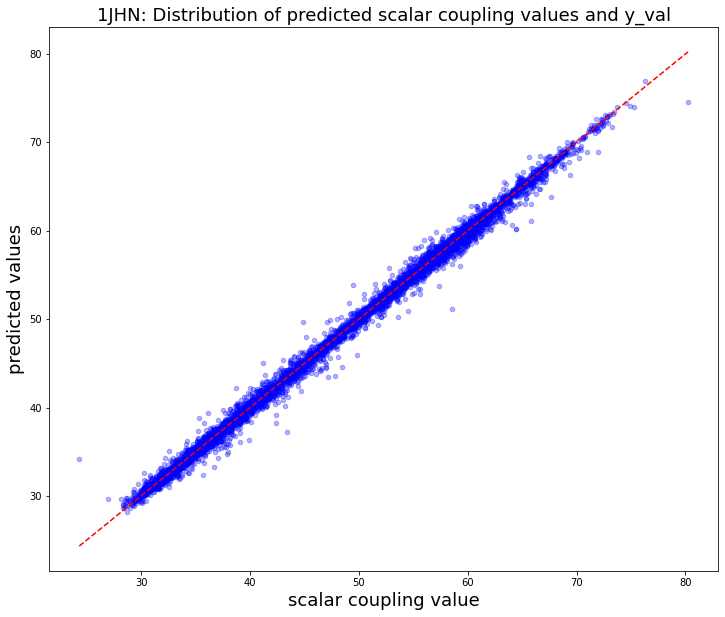

In [32]:
plt.figure(figsize=(12,10))
plt.scatter(y_val, y_pred,alpha=0.3, s=20, c='b', marker='o')
plt.title('1JHN: Distribution of predicted scalar coupling values and y_val', fontsize=18)
plt.xlabel("scalar coupling value", fontsize=18)
plt.ylabel("predicted values", fontsize=18)
plt.plot([min(y_val),max(y_val)],[min(y_val),max(y_val)], "r--")
plt.show()

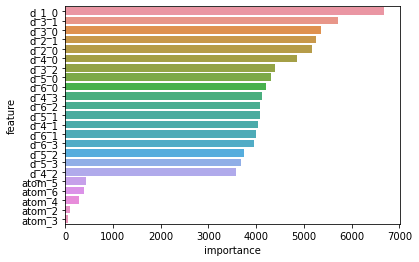

In [33]:
cols = list(df.columns)
cols.remove('scalar_coupling_constant')
cols
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

# experiment other models with the smallest dataset

* Lasso
* Ridge
* ElasticNet
* DecisionTreeRegressor
* RandomForestRegressor
* KMeans
* DBSCAN
* MLPRegressor (Multilayer Perceptron)
* GradientBoostingRegressor
* VotingRegressor
* StackingRegressor
* KerasRegressor





In [34]:
%%time

# When I used algorithm for classification problems such as
# SVC, KNN, LogisticRegression, DecisionTreeClassifier, AdaBoostClassifier, MLPClassifier, RandomForestClassifier
# I got an error, "Unknown label type: 'continuous'"
# GaussianNB is also for classification problems


# Using regularized methods for regression
# Lasso
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f'Lasso_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')

# Ridge
from sklearn.linear_model import Ridge
model = Ridge(alpha=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f'Ridge_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')

# ElasticNet
from sklearn.linear_model import ElasticNet
model = ElasticNet(alpha=1.0, l1_ratio=0.5)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f'ElasticNet_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')

# Decision tree regression
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=9)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f'DecisionTreeRegressor_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')

## Random forest regression
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=10, 
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f'RandomForestRegressor_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')
# n_estimators=1000 gives -0.8611445248284487, also takes a lot of time

# KMeans
from sklearn.cluster import KMeans
model = KMeans(n_clusters=2, 
            init='random', 
            n_init=10, 
            max_iter=1000,
            tol=1e-04,
            random_state=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f'KMeans_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')

# DBSCAN
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
model.fit(X_train, y_train)
y_pred = model.fit_predict(X_val)
print(f'DBSCAN_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')

# MLPRegressor
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(
    hidden_layer_sizes=(100,),  activation='relu', solver='adam', alpha=0.001, batch_size='auto',
    learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
    random_state=0, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f'MLPRegressor_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')


# ensemble learning models other than RandomForest
# GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,max_depth=9, random_state=0, loss='ls')
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print(f'GradientBoostingRegressor_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')

## from sklearn.datasets import load_boston
## from sklearn.ensemble import GradientBoostingRegressor
## from sklearn.ensemble import RandomForestRegressor
## from sklearn.linear_model import LinearRegression
## from sklearn.ensemble import VotingRegressor
## reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)
## reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
## reg3 = LinearRegression()
## model = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
## model.fit(X_train, y_train)
## y_pred = model.predict(X_val)
## print(f'VotingRegressor_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')
# # Takes long time to calculate: VotingRegressor_MAE_log: 0.46833474323080804

## from sklearn.linear_model import RidgeCV, LassoCV
## from sklearn.svm import SVR
## estimators = [('ridge', RidgeCV()),
##              ('lasso', LassoCV(random_state=42)),
##               ('svr', SVR(C=1, gamma=1e-6))]
## from sklearn.ensemble import GradientBoostingRegressor
## from sklearn.ensemble import StackingRegressor
## model = StackingRegressor(
##      estimators=estimators,
##     final_estimator=GradientBoostingRegressor(random_state=42))
## model.fit(X_train, y_train)
## y_pred = model.predict(X_val)
## print(f'StackingRegressor_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')
## # Takes a lot of calculation time: StackingRegressor_MAE_log: 0.3828974855958835

## KerasRegressor
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasRegressor

# def baseline_model():
#     # create model
#     model = Sequential()
#     model.add(Dense(23, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
#     model.add(Dense(1, kernel_initializer='normal'))
#     # Compile model
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     return model

# model = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_val)
# print(f'KerasRegressor_MAE_log: {np.log(mean_absolute_error(y_val, y_pred))}')
# # Takes a lot of computing time: KerasRegressor_MAE_log: 0.32364046573638916




Lasso_MAE_log: 1.3380218744277954
Ridge_MAE_log: 0.5069612264633179
ElasticNet_MAE_log: 1.8988251686096191
DecisionTreeRegressor_MAE_log: 0.028231697862193452
RandomForestRegressor_MAE_log: -0.7615371726538203
KMeans_MAE_log: 3.8522727591892547
DBSCAN_MAE_log: 4.378636043553338
MLPRegressor_MAE_log: 0.2555339863694306
GradientBoostingRegressor_MAE_log: -0.7958808280564267
CPU times: user 1min 54s, sys: 2.31 s, total: 1min 56s
Wall time: 1min 38s


# Experiment XGBoost regression
## XGBoost has a similar performance to LightGBM, but requires more computation time.
## At least 5 times longer to have a similar performance.

In [64]:
%%time

import xgboost as xgb

# data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

XGB_PARAMS = {
    'objective': 'reg:squarederror',
    'metric': 'mae',
    'verbosity': 1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 128,
    'min_child_samples': 79,
    'max_depth': 9,
    'subsample_freq': 1,
    'subsample': 0.9,
    'bagging_seed': 11,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0
}

model = xgb.XGBRegressor(**XGB_PARAMS, n_estimators=700, n_jobs = -1)


model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=200)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

[0]	validation_0-mae:42.27733	validation_1-mae:42.36795
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.
[100]	validation_0-mae:0.31077	validation_1-mae:0.46417
[200]	validation_0-mae:0.22891	validation_1-mae:0.42723
[300]	validation_0-mae:0.17581	validation_1-mae:0.40662
[400]	validation_0-mae:0.14103	validation_1-mae:0.39512
[500]	validation_0-mae:0.11702	validation_1-mae:0.38865
[600]	validation_0-mae:0.09741	validation_1-mae:0.38333
[699]	validation_0-mae:0.08314	validation_1-mae:0.37961
CPU times: user 2min 17s, sys: 355 ms, total: 2min 18s
Wall time: 2min 21s


-0.9686092

# LightGBM model with the whole dataset

In [261]:
def build_x_y_data(some_csv, coupling_type, n_atoms):
    full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)
    
    df = take_n_atoms(full, n_atoms)
    df = df.fillna(0)
    print(df.columns)
    
    if 'scalar_coupling_constant' in df:
        X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
        y_data = df['scalar_coupling_constant'].values.astype('float32')
    else:
        X_data = df.values.astype('float32')
        y_data = None
    
    return X_data, y_data

In [262]:
def train_and_predict_for_one_coupling_type(coupling_type, output_result, n_atoms, n_folds=5, n_splits=5, random_state=128):
    print(f'*** Training Model for {coupling_type} ***')
    
    # to build X_data and y_data for training
    X_data, y_data = build_x_y_data(train_csv, coupling_type, n_atoms)
    
    # test_csv doesn't have scaler coupling values, so no y_test
    X_test, _ = build_x_y_data(test_csv, coupling_type, n_atoms)
    
    # Note: The shape attribute for numpy arrays returns the dimensions of the array.
    # If Y has n rows and m columns, then Y.shape is (n,m). So Y.shape[0] is n.
    # X_test.shape[0] gives # of rows in X_test dataframe
    y_pred = np.zeros(X_test.shape[0], dtype='float32')

    cv_score = 0
    
    if n_folds > n_splits:
        n_splits = n_folds
    
    # K-Folds cross-validator
    # Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds.
    # Each fold is then used once as a validation while the k - 1 remaining folds form the training set.
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data)):
        if fold >= n_folds:
            break
        
        # for each fold, form X_train, X_val, y_train, y_val by generated train and val index
        X_train, X_val = X_data[train_index], X_data[val_index]
        y_train, y_val = y_data[train_index], y_data[val_index]

        model = LGBMRegressor(**LGB_PARAMS, n_estimators=1500, n_jobs = -1)
        model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
            verbose=100, early_stopping_rounds=200)

        y_val_pred = model.predict(X_val)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}')
        
        plt.figure(figsize=(12,10))
        plt.scatter(y_val, y_val_pred,alpha=0.3, s=20, c='b', marker='o')
        plt.title(f'{coupling_type} Fold {fold}: Distribution of predicted scalar coupling values and y_val', fontsize=18)
        plt.xlabel("scalar coupling value", fontsize=18)
        plt.ylabel("predicted values", fontsize=18)
        plt.plot([min(y_val),max(y_val)],[min(y_val),max(y_val)], "r--")
        plt.show()
        
        cv_score += val_score / n_folds
        y_pred += model.predict(X_test) / n_folds
        
    output_result.loc[test_csv['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    return cv_score

Let's build a separate model for each type of coupling. Dataset is split into 5 pieces and in this kernel we will use only 3 folds for speed up.

Main tuning parameter is the number of atoms. I took good numbers, but accuracy can be improved a bit by tuning them for each type.

*** Training Model for 1JHN ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'd_1_0', 'd_2_0',
       'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3',
       'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3'],
      dtype='object')
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.42546	valid_1's l1: 0.512916
[200]	training's l1: 0.350466	valid_1's l1: 0.466946
[300]	training's l1: 0.304485	valid_1's l1: 0.443062
[400]	training's l1: 0.270928	valid_1's l1: 0.428571
[500]	training's l1: 0.24356	valid_1's l1: 0.416902
[600]	training's l1: 0.220745	valid_1's l1: 0.40898
[700]	training's l1: 0.203629	valid_1's l1: 

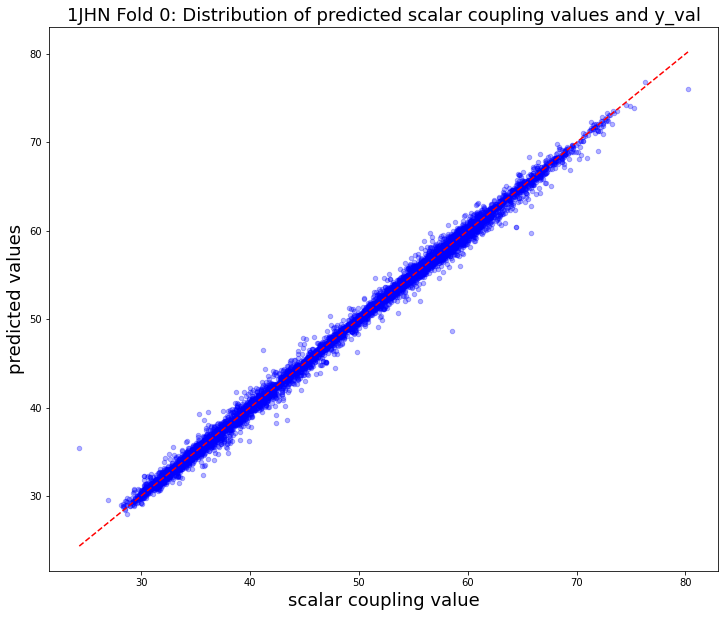

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.421413	valid_1's l1: 0.507317
[200]	training's l1: 0.351944	valid_1's l1: 0.466693
[300]	training's l1: 0.305584	valid_1's l1: 0.443877
[400]	training's l1: 0.271516	valid_1's l1: 0.428017
[500]	training's l1: 0.246468	valid_1's l1: 0.418915
[600]	training's l1: 0.224333	valid_1's l1: 0.411432
[700]	training's l1: 0.206793	valid_1's l1: 0.405719
[800]	training's l1: 0.191236	valid_1's l1: 0.401028
[900]	training's l1: 0.176944	valid_1's l1: 0.397125
[1000]	training's l1: 0.164479	valid_1's l1: 0.394234
[1100]	training's l1: 0.154356	valid_1's l1: 0.391568
[1200]	training's l1: 0.144544	valid_1's l1: 0.389169
[1300]	training's l1: 0.136244	valid_1's l1: 0.387198
[1400]	training's l1: 0.128085	valid_1's l1: 0.385516
[1500]	training's l1: 0.120612	valid_1's l1: 0.383716
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.120612	valid_1's l1: 0.383716
1JHN Fold 1, logMAE: -0.95785331295

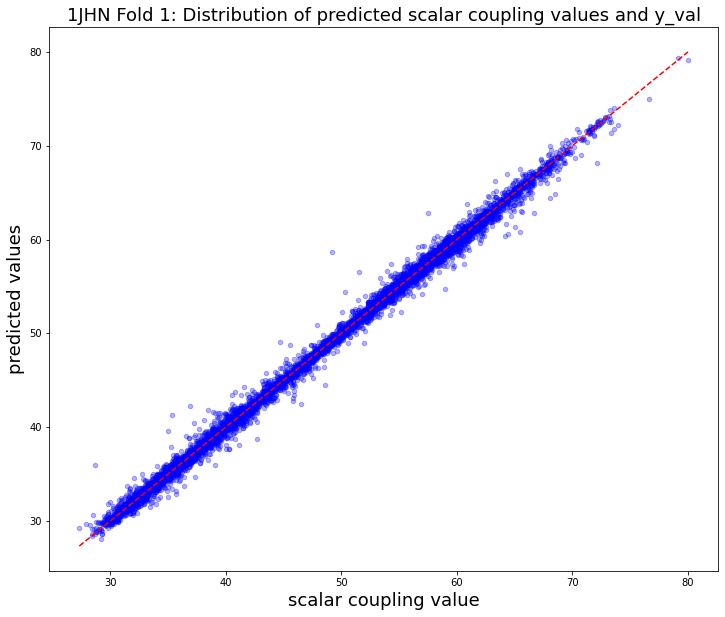

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.422706	valid_1's l1: 0.523672
[200]	training's l1: 0.35085	valid_1's l1: 0.477712
[300]	training's l1: 0.303982	valid_1's l1: 0.453176
[400]	training's l1: 0.269558	valid_1's l1: 0.438117
[500]	training's l1: 0.242266	valid_1's l1: 0.426933
[600]	training's l1: 0.221714	valid_1's l1: 0.419405
[700]	training's l1: 0.204041	valid_1's l1: 0.414118
[800]	training's l1: 0.189614	valid_1's l1: 0.409443
[900]	training's l1: 0.176214	valid_1's l1: 0.405759
[1000]	training's l1: 0.164456	valid_1's l1: 0.403021
[1100]	training's l1: 0.153436	valid_1's l1: 0.399972
[1200]	training's l1: 0.144403	valid_1's l1: 0.3979
[1300]	training's l1: 0.136382	valid_1's l1: 0.395995
[1400]	training's l1: 0.12826	valid_1's l1: 0.394257
[1500]	training's l1: 0.120936	valid_1's l1: 0.392969
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.120936	valid_1's l1: 0.392969
1JHN Fold 2, logMAE: -0.934024212129652

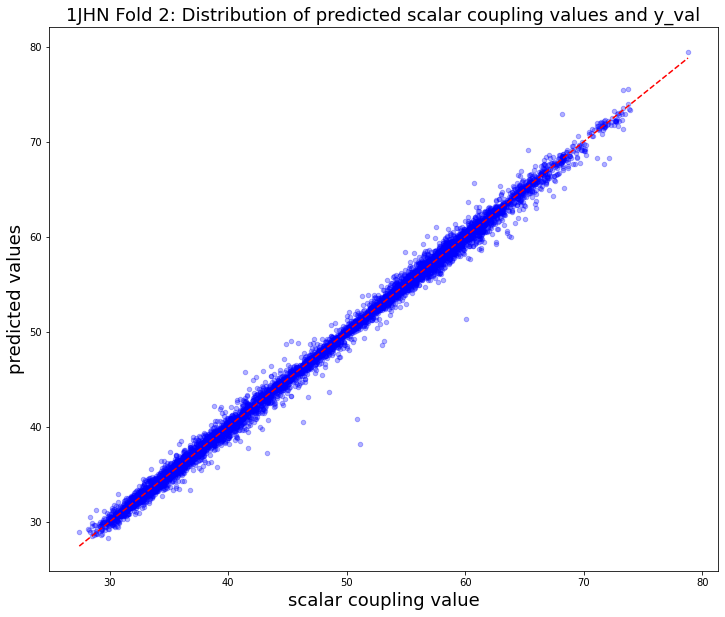

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.420041	valid_1's l1: 0.513128
[200]	training's l1: 0.345661	valid_1's l1: 0.468936
[300]	training's l1: 0.299306	valid_1's l1: 0.447316
[400]	training's l1: 0.265098	valid_1's l1: 0.431322
[500]	training's l1: 0.241343	valid_1's l1: 0.420877
[600]	training's l1: 0.220808	valid_1's l1: 0.414021
[700]	training's l1: 0.203169	valid_1's l1: 0.407754
[800]	training's l1: 0.188272	valid_1's l1: 0.402808
[900]	training's l1: 0.174732	valid_1's l1: 0.398207
[1000]	training's l1: 0.162813	valid_1's l1: 0.39487
[1100]	training's l1: 0.15234	valid_1's l1: 0.391892
[1200]	training's l1: 0.14259	valid_1's l1: 0.389279
[1300]	training's l1: 0.13428	valid_1's l1: 0.387272
[1400]	training's l1: 0.126571	valid_1's l1: 0.385222
[1500]	training's l1: 0.119923	valid_1's l1: 0.383604
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.119923	valid_1's l1: 0.383604
1JHN Fold 3, logMAE: -0.958143500407986

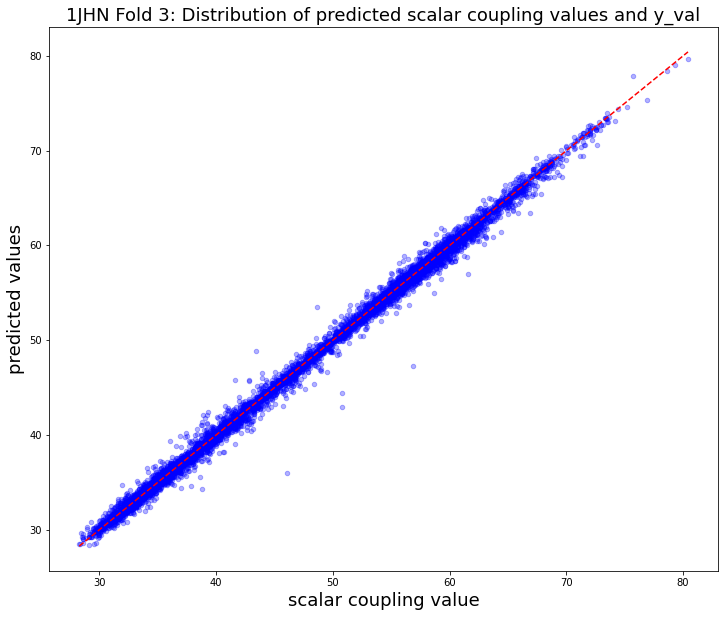

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.424057	valid_1's l1: 0.52438
[200]	training's l1: 0.348864	valid_1's l1: 0.477416
[300]	training's l1: 0.301968	valid_1's l1: 0.45219
[400]	training's l1: 0.267918	valid_1's l1: 0.43544
[500]	training's l1: 0.24171	valid_1's l1: 0.423918
[600]	training's l1: 0.219749	valid_1's l1: 0.415448
[700]	training's l1: 0.202394	valid_1's l1: 0.408852
[800]	training's l1: 0.186844	valid_1's l1: 0.404019
[900]	training's l1: 0.172972	valid_1's l1: 0.40007
[1000]	training's l1: 0.16163	valid_1's l1: 0.39676
[1100]	training's l1: 0.150842	valid_1's l1: 0.393405
[1200]	training's l1: 0.141088	valid_1's l1: 0.391071
[1300]	training's l1: 0.132899	valid_1's l1: 0.389047
[1400]	training's l1: 0.124972	valid_1's l1: 0.387381
[1500]	training's l1: 0.117973	valid_1's l1: 0.385844
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.117973	valid_1's l1: 0.385844
1JHN Fold 4, logMAE: -0.9523213222045528


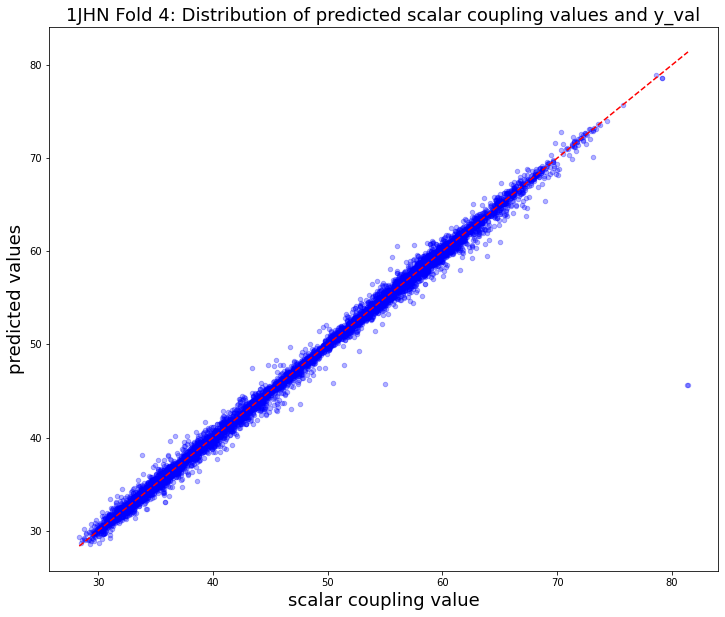

*** Training Model for 1JHC ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0',
       'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0',
       'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0',
       'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3',
       'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0',
       'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0',
       'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0',
       'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3'],
      dtype='object')
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 1.16431	valid_1's l1: 1.21153
[200

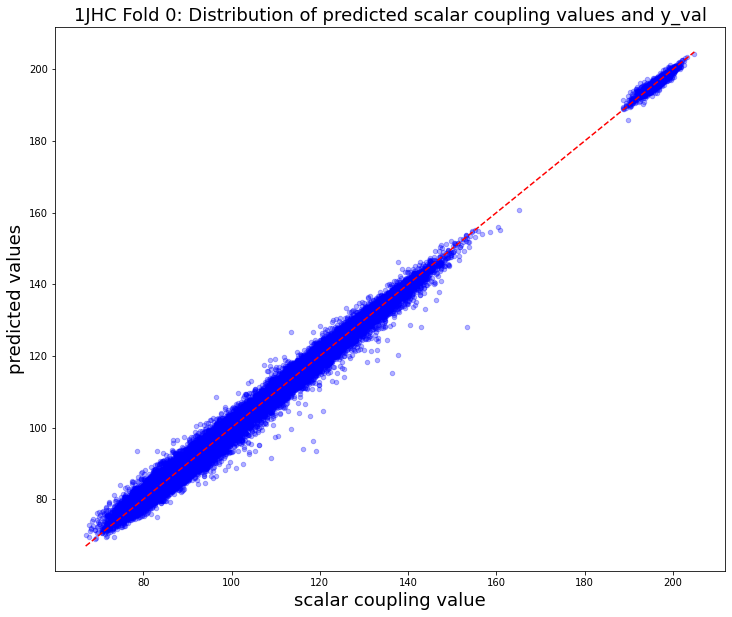

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 1.17027	valid_1's l1: 1.21252
[200]	training's l1: 0.996251	valid_1's l1: 1.06905
[300]	training's l1: 0.89559	valid_1's l1: 0.993396
[400]	training's l1: 0.824485	valid_1's l1: 0.943494
[500]	training's l1: 0.769718	valid_1's l1: 0.907084
[600]	training's l1: 0.726563	valid_1's l1: 0.880596
[700]	training's l1: 0.691096	valid_1's l1: 0.859942
[800]	training's l1: 0.659631	valid_1's l1: 0.842115
[900]	training's l1: 0.631702	valid_1's l1: 0.827527
[1000]	training's l1: 0.607049	valid_1's l1: 0.814525
[1100]	training's l1: 0.584421	valid_1's l1: 0.802928
[1200]	training's l1: 0.563997	valid_1's l1: 0.793202
[1300]	training's l1: 0.545254	valid_1's l1: 0.784569
[1400]	training's l1: 0.527825	valid_1's l1: 0.77676
[1500]	training's l1: 0.511829	valid_1's l1: 0.769611
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.511829	valid_1's l1: 0.769611
1JHC Fold 1, logMAE: -0.261870006885334


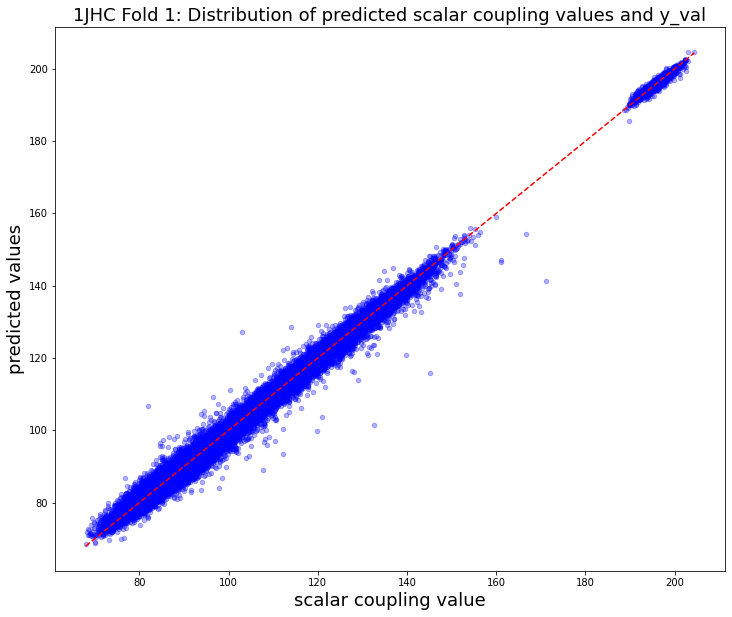

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 1.16247	valid_1's l1: 1.22505
[200]	training's l1: 0.989882	valid_1's l1: 1.08089
[300]	training's l1: 0.895244	valid_1's l1: 1.01052
[400]	training's l1: 0.82552	valid_1's l1: 0.961183
[500]	training's l1: 0.773583	valid_1's l1: 0.92694
[600]	training's l1: 0.729844	valid_1's l1: 0.899518
[700]	training's l1: 0.693312	valid_1's l1: 0.877544
[800]	training's l1: 0.661677	valid_1's l1: 0.859785
[900]	training's l1: 0.633062	valid_1's l1: 0.843977
[1000]	training's l1: 0.608147	valid_1's l1: 0.830953
[1100]	training's l1: 0.585887	valid_1's l1: 0.819996
[1200]	training's l1: 0.565363	valid_1's l1: 0.810555
[1300]	training's l1: 0.546224	valid_1's l1: 0.801737
[1400]	training's l1: 0.529004	valid_1's l1: 0.793908
[1500]	training's l1: 0.512619	valid_1's l1: 0.786655
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.512619	valid_1's l1: 0.786655
1JHC Fold 2, logMAE: -0.23996601945528448

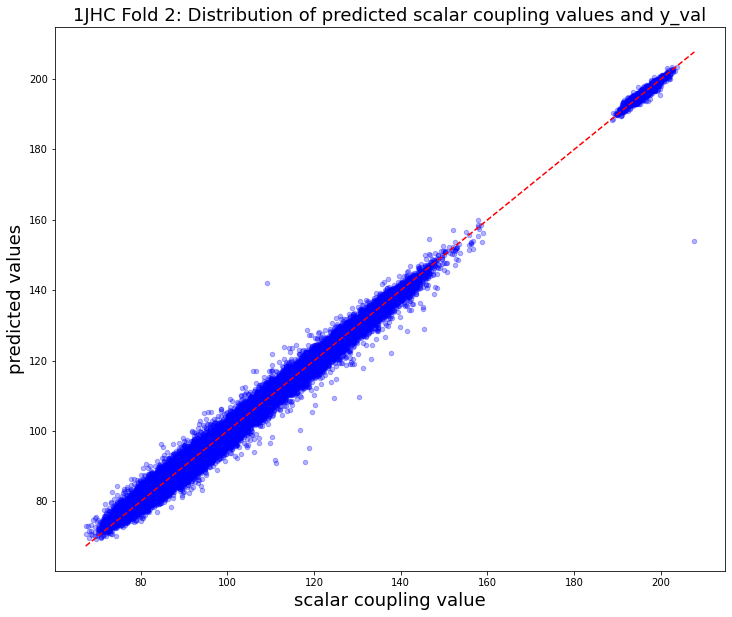

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 1.16793	valid_1's l1: 1.2221
[200]	training's l1: 0.995975	valid_1's l1: 1.07712
[300]	training's l1: 0.895462	valid_1's l1: 1.00103
[400]	training's l1: 0.826177	valid_1's l1: 0.951774
[500]	training's l1: 0.773754	valid_1's l1: 0.917821
[600]	training's l1: 0.730322	valid_1's l1: 0.890425
[700]	training's l1: 0.692946	valid_1's l1: 0.868487
[800]	training's l1: 0.662267	valid_1's l1: 0.851238
[900]	training's l1: 0.634111	valid_1's l1: 0.835402
[1000]	training's l1: 0.609305	valid_1's l1: 0.822589
[1100]	training's l1: 0.587118	valid_1's l1: 0.811498
[1200]	training's l1: 0.566496	valid_1's l1: 0.801776
[1300]	training's l1: 0.547841	valid_1's l1: 0.793622
[1400]	training's l1: 0.530338	valid_1's l1: 0.785986
[1500]	training's l1: 0.513984	valid_1's l1: 0.779084
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.513984	valid_1's l1: 0.779084
1JHC Fold 3, logMAE: -0.2496369846528190

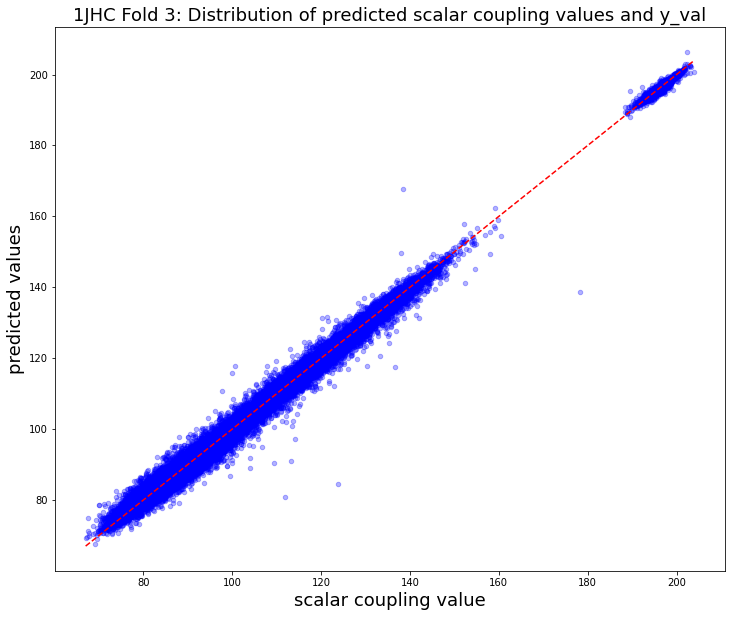

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 1.16894	valid_1's l1: 1.22042
[200]	training's l1: 0.993883	valid_1's l1: 1.07347
[300]	training's l1: 0.893407	valid_1's l1: 0.996099
[400]	training's l1: 0.824947	valid_1's l1: 0.948966
[500]	training's l1: 0.77075	valid_1's l1: 0.913719
[600]	training's l1: 0.727706	valid_1's l1: 0.887294
[700]	training's l1: 0.692662	valid_1's l1: 0.867098
[800]	training's l1: 0.661509	valid_1's l1: 0.849557
[900]	training's l1: 0.63432	valid_1's l1: 0.835205
[1000]	training's l1: 0.609642	valid_1's l1: 0.822706
[1100]	training's l1: 0.587295	valid_1's l1: 0.81165
[1200]	training's l1: 0.566663	valid_1's l1: 0.801908
[1300]	training's l1: 0.548371	valid_1's l1: 0.793454
[1400]	training's l1: 0.530601	valid_1's l1: 0.785312
[1500]	training's l1: 0.514773	valid_1's l1: 0.7786
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.514773	valid_1's l1: 0.7786
1JHC Fold 4, logMAE: -0.2502580272025862


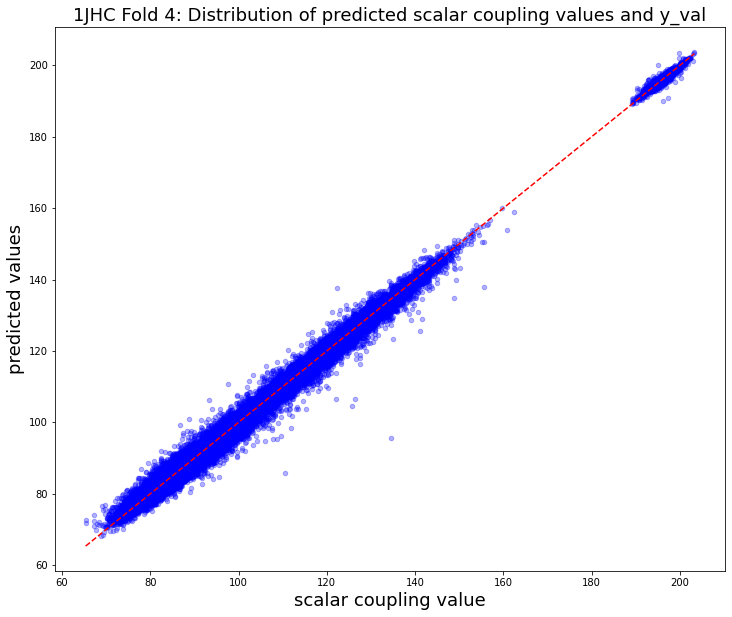

*** Training Model for 2JHH ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3', 'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3'],
      dtype='object')
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.256634	valid_1's l1: 0.277927
[200]	training's l1: 0.208814	valid_1's l1: 0.241634
[300]	training's l1: 0.185035	valid_1's l1: 0.22

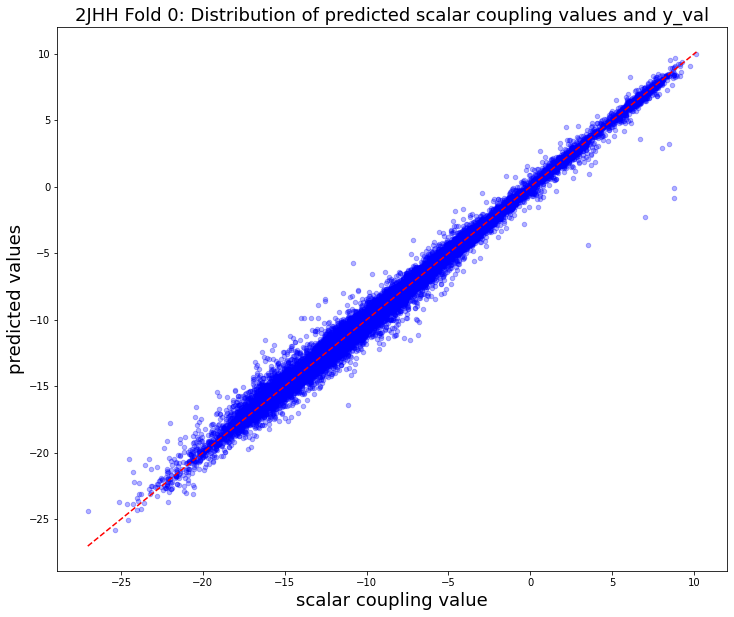

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.254093	valid_1's l1: 0.275538
[200]	training's l1: 0.208593	valid_1's l1: 0.241112
[300]	training's l1: 0.184244	valid_1's l1: 0.224709
[400]	training's l1: 0.167353	valid_1's l1: 0.214606
[500]	training's l1: 0.154505	valid_1's l1: 0.20736
[600]	training's l1: 0.143939	valid_1's l1: 0.202008
[700]	training's l1: 0.135166	valid_1's l1: 0.197799
[800]	training's l1: 0.127124	valid_1's l1: 0.193898
[900]	training's l1: 0.120143	valid_1's l1: 0.190894
[1000]	training's l1: 0.114316	valid_1's l1: 0.188337
[1100]	training's l1: 0.109041	valid_1's l1: 0.186172
[1200]	training's l1: 0.104049	valid_1's l1: 0.184283
[1300]	training's l1: 0.0993979	valid_1's l1: 0.182571
[1400]	training's l1: 0.0954259	valid_1's l1: 0.181201
[1500]	training's l1: 0.0917571	valid_1's l1: 0.18002
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0917571	valid_1's l1: 0.18002
2JHH Fold 1, logMAE: -1.7146860759

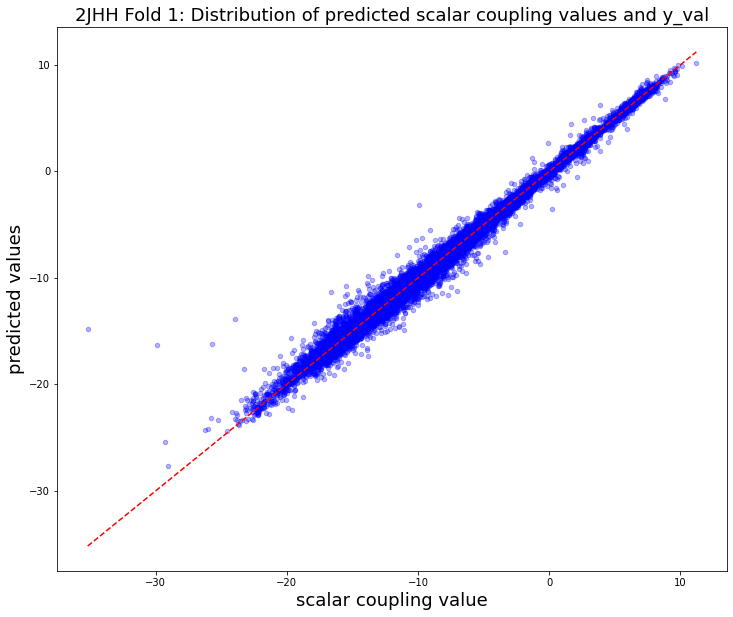

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.255484	valid_1's l1: 0.277876
[200]	training's l1: 0.20817	valid_1's l1: 0.241799
[300]	training's l1: 0.1841	valid_1's l1: 0.226021
[400]	training's l1: 0.167145	valid_1's l1: 0.215772
[500]	training's l1: 0.154086	valid_1's l1: 0.208569
[600]	training's l1: 0.143885	valid_1's l1: 0.203142
[700]	training's l1: 0.134824	valid_1's l1: 0.198685
[800]	training's l1: 0.127413	valid_1's l1: 0.195334
[900]	training's l1: 0.120622	valid_1's l1: 0.192286
[1000]	training's l1: 0.114582	valid_1's l1: 0.189674
[1100]	training's l1: 0.109099	valid_1's l1: 0.187325
[1200]	training's l1: 0.104027	valid_1's l1: 0.185153
[1300]	training's l1: 0.0995153	valid_1's l1: 0.183472
[1400]	training's l1: 0.0955202	valid_1's l1: 0.181967
[1500]	training's l1: 0.0917038	valid_1's l1: 0.180582
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0917038	valid_1's l1: 0.180582
2JHH Fold 2, logMAE: -1.7115695283

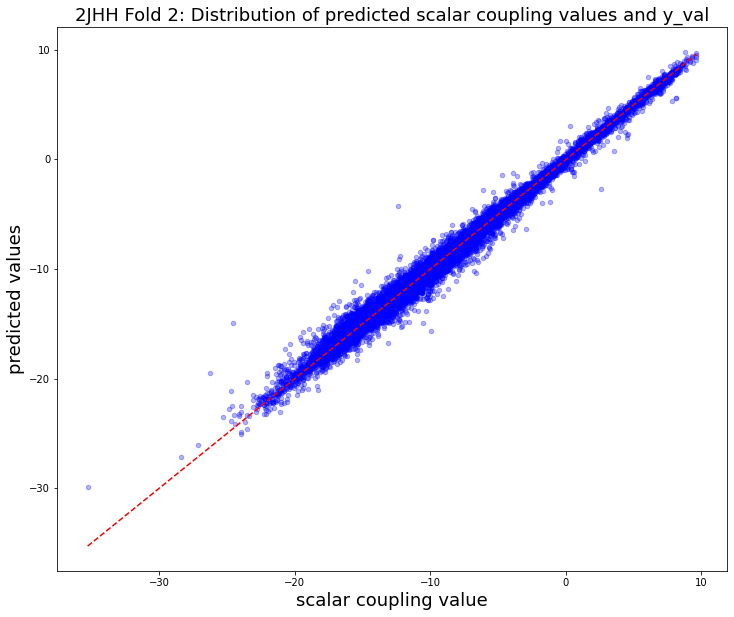

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.255669	valid_1's l1: 0.27836
[200]	training's l1: 0.206569	valid_1's l1: 0.240522
[300]	training's l1: 0.182966	valid_1's l1: 0.224686
[400]	training's l1: 0.165749	valid_1's l1: 0.214565
[500]	training's l1: 0.153277	valid_1's l1: 0.207549
[600]	training's l1: 0.142571	valid_1's l1: 0.201774
[700]	training's l1: 0.133607	valid_1's l1: 0.197368
[800]	training's l1: 0.125964	valid_1's l1: 0.193836
[900]	training's l1: 0.119512	valid_1's l1: 0.191003
[1000]	training's l1: 0.113586	valid_1's l1: 0.188476
[1100]	training's l1: 0.108332	valid_1's l1: 0.186338
[1200]	training's l1: 0.103602	valid_1's l1: 0.184386
[1300]	training's l1: 0.0991783	valid_1's l1: 0.182681
[1400]	training's l1: 0.0950971	valid_1's l1: 0.181179
[1500]	training's l1: 0.091371	valid_1's l1: 0.179797
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.091371	valid_1's l1: 0.179797
2JHH Fold 3, logMAE: -1.7159250985

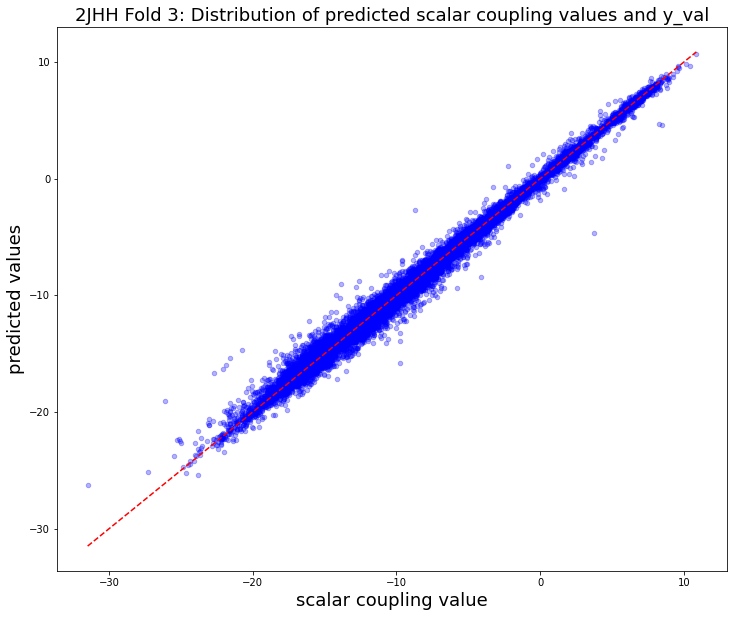

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.2539	valid_1's l1: 0.276474
[200]	training's l1: 0.207557	valid_1's l1: 0.24027
[300]	training's l1: 0.182155	valid_1's l1: 0.222931
[400]	training's l1: 0.165431	valid_1's l1: 0.212665
[500]	training's l1: 0.153462	valid_1's l1: 0.206298
[600]	training's l1: 0.14268	valid_1's l1: 0.200507
[700]	training's l1: 0.133899	valid_1's l1: 0.196453
[800]	training's l1: 0.126243	valid_1's l1: 0.192983
[900]	training's l1: 0.119799	valid_1's l1: 0.190162
[1000]	training's l1: 0.113707	valid_1's l1: 0.187671
[1100]	training's l1: 0.108269	valid_1's l1: 0.18556
[1200]	training's l1: 0.103618	valid_1's l1: 0.183776
[1300]	training's l1: 0.0990079	valid_1's l1: 0.182055
[1400]	training's l1: 0.095019	valid_1's l1: 0.180576
[1500]	training's l1: 0.0913474	valid_1's l1: 0.179216
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0913474	valid_1's l1: 0.179216
2JHH Fold 4, logMAE: -1.7191612371728

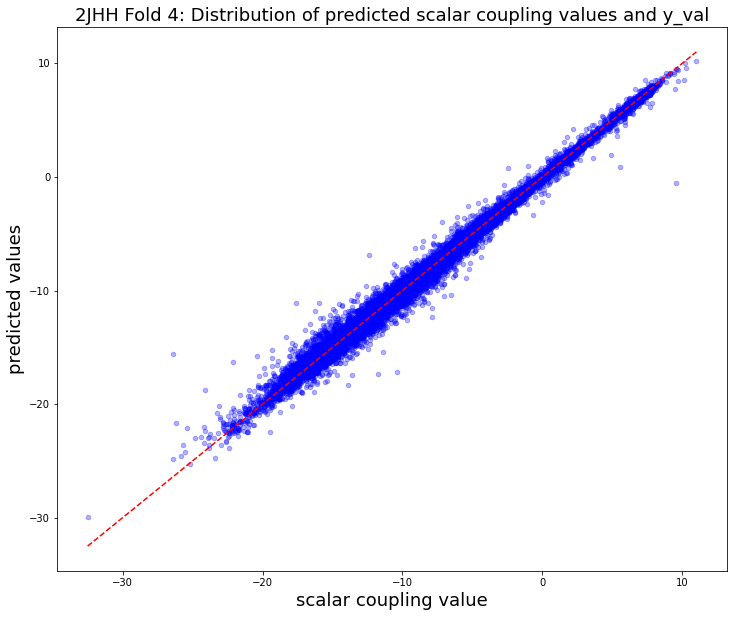

*** Training Model for 2JHN ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3', 'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3'],
      dtype='object')
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.185834	valid_1's l1: 0.219574
[200]	training's l1: 0.151191	valid_1's l1: 0.194358
[300]	training's l1: 0.132272	valid_1's l1: 0.18

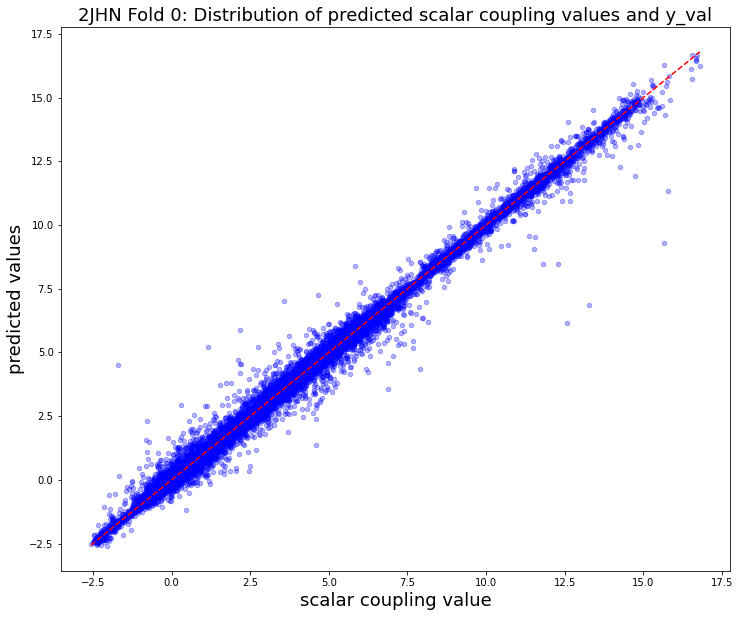

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.185004	valid_1's l1: 0.21384
[200]	training's l1: 0.150111	valid_1's l1: 0.189988
[300]	training's l1: 0.129896	valid_1's l1: 0.178156
[400]	training's l1: 0.117054	valid_1's l1: 0.170873
[500]	training's l1: 0.106603	valid_1's l1: 0.165852
[600]	training's l1: 0.098038	valid_1's l1: 0.162022
[700]	training's l1: 0.0908075	valid_1's l1: 0.158922
[800]	training's l1: 0.0844061	valid_1's l1: 0.156331
[900]	training's l1: 0.0790988	valid_1's l1: 0.154478
[1000]	training's l1: 0.0742267	valid_1's l1: 0.152506
[1100]	training's l1: 0.0694733	valid_1's l1: 0.150711
[1200]	training's l1: 0.0655926	valid_1's l1: 0.149202
[1300]	training's l1: 0.0621282	valid_1's l1: 0.147985
[1400]	training's l1: 0.0587435	valid_1's l1: 0.146867
[1500]	training's l1: 0.0557186	valid_1's l1: 0.145971
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0557186	valid_1's l1: 0.145971
2JHN Fold 1, logMAE: -1.92

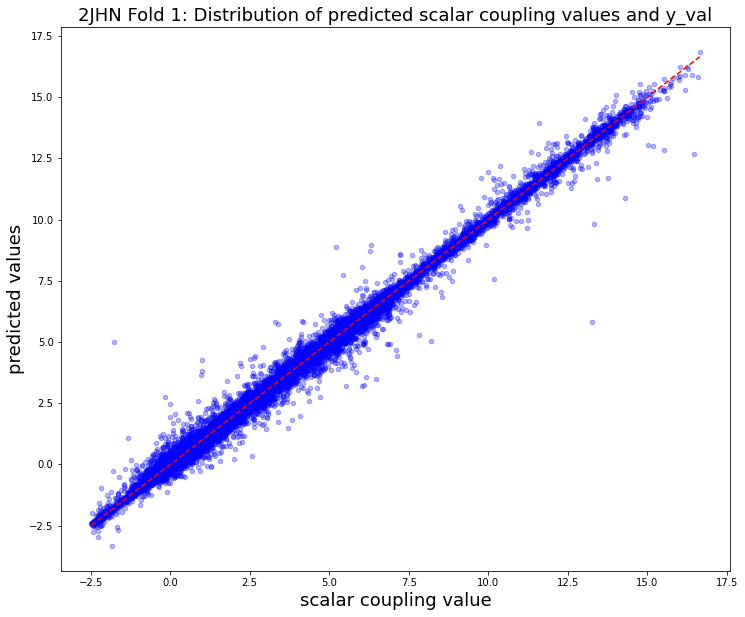

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.189087	valid_1's l1: 0.220435
[200]	training's l1: 0.154806	valid_1's l1: 0.195844
[300]	training's l1: 0.133896	valid_1's l1: 0.182696
[400]	training's l1: 0.119292	valid_1's l1: 0.174499
[500]	training's l1: 0.108458	valid_1's l1: 0.168978
[600]	training's l1: 0.0988164	valid_1's l1: 0.1643
[700]	training's l1: 0.0909531	valid_1's l1: 0.16069
[800]	training's l1: 0.0844339	valid_1's l1: 0.158003
[900]	training's l1: 0.0787502	valid_1's l1: 0.155653
[1000]	training's l1: 0.0736833	valid_1's l1: 0.153654
[1100]	training's l1: 0.0691644	valid_1's l1: 0.151996
[1200]	training's l1: 0.0651734	valid_1's l1: 0.150629
[1300]	training's l1: 0.061488	valid_1's l1: 0.149455
[1400]	training's l1: 0.0580428	valid_1's l1: 0.148334
[1500]	training's l1: 0.0550599	valid_1's l1: 0.147344
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0550599	valid_1's l1: 0.147344
2JHN Fold 2, logMAE: -1.9149

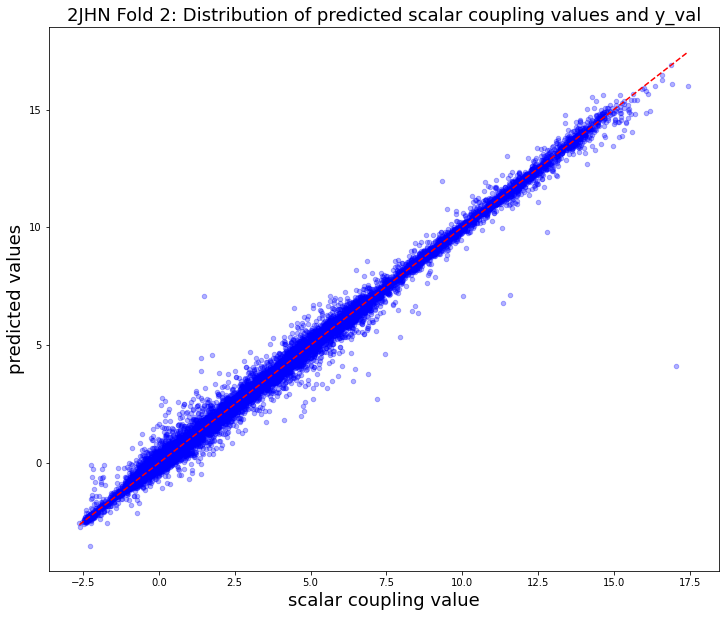

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.186371	valid_1's l1: 0.216627
[200]	training's l1: 0.151169	valid_1's l1: 0.191642
[300]	training's l1: 0.131765	valid_1's l1: 0.179772
[400]	training's l1: 0.117409	valid_1's l1: 0.172184
[500]	training's l1: 0.106884	valid_1's l1: 0.166823
[600]	training's l1: 0.0978582	valid_1's l1: 0.16247
[700]	training's l1: 0.0905623	valid_1's l1: 0.159323
[800]	training's l1: 0.0843318	valid_1's l1: 0.156688
[900]	training's l1: 0.0790766	valid_1's l1: 0.154644
[1000]	training's l1: 0.0741128	valid_1's l1: 0.152698
[1100]	training's l1: 0.0697556	valid_1's l1: 0.150989
[1200]	training's l1: 0.0656332	valid_1's l1: 0.149528
[1300]	training's l1: 0.0619947	valid_1's l1: 0.148283
[1400]	training's l1: 0.0585416	valid_1's l1: 0.14699
[1500]	training's l1: 0.0556825	valid_1's l1: 0.146086
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0556825	valid_1's l1: 0.146086
2JHN Fold 3, logMAE: -1.92

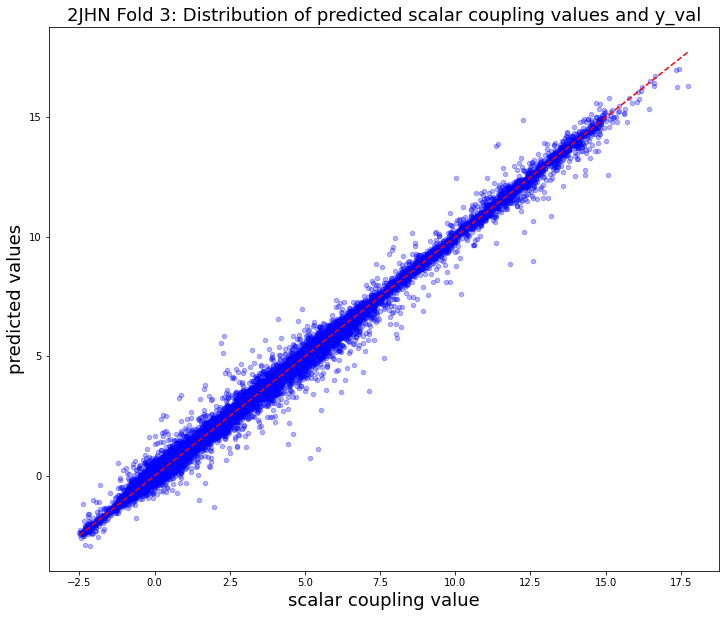

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.187497	valid_1's l1: 0.216455
[200]	training's l1: 0.152338	valid_1's l1: 0.191742
[300]	training's l1: 0.132634	valid_1's l1: 0.179762
[400]	training's l1: 0.118794	valid_1's l1: 0.171878
[500]	training's l1: 0.108286	valid_1's l1: 0.166473
[600]	training's l1: 0.0994089	valid_1's l1: 0.162419
[700]	training's l1: 0.0918199	valid_1's l1: 0.159102
[800]	training's l1: 0.0858285	valid_1's l1: 0.156601
[900]	training's l1: 0.0803691	valid_1's l1: 0.154527
[1000]	training's l1: 0.0756011	valid_1's l1: 0.15264
[1100]	training's l1: 0.0712935	valid_1's l1: 0.151155
[1200]	training's l1: 0.0671617	valid_1's l1: 0.149754
[1300]	training's l1: 0.0634184	valid_1's l1: 0.148393
[1400]	training's l1: 0.0600679	valid_1's l1: 0.14716
[1500]	training's l1: 0.0570243	valid_1's l1: 0.146172
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0570243	valid_1's l1: 0.146172
2JHN Fold 4, logMAE: -1.92

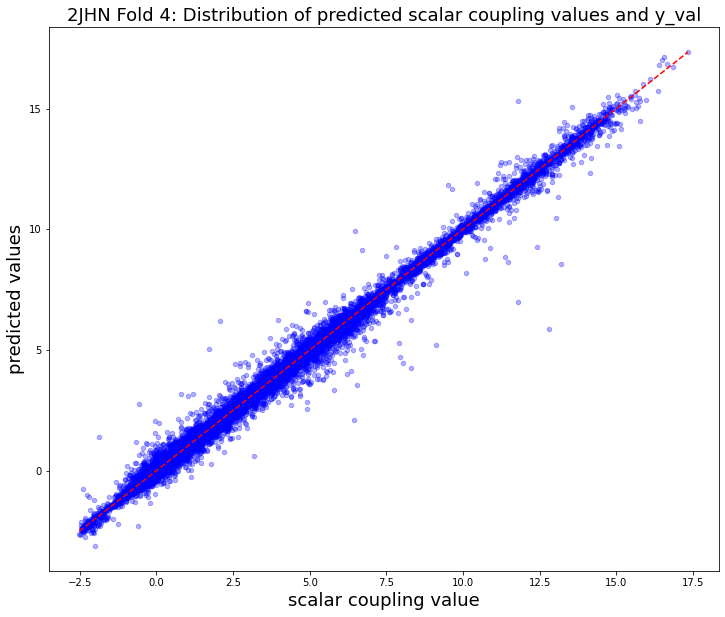

*** Training Model for 2JHC ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3', 'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3'],
      dtype='object')
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.501513	valid_1's l1: 0.516946
[200]	training's l1: 0.423412	valid_1's l1: 0.447681
[300]	training's l1: 0.382771	valid_1's l1: 0.41

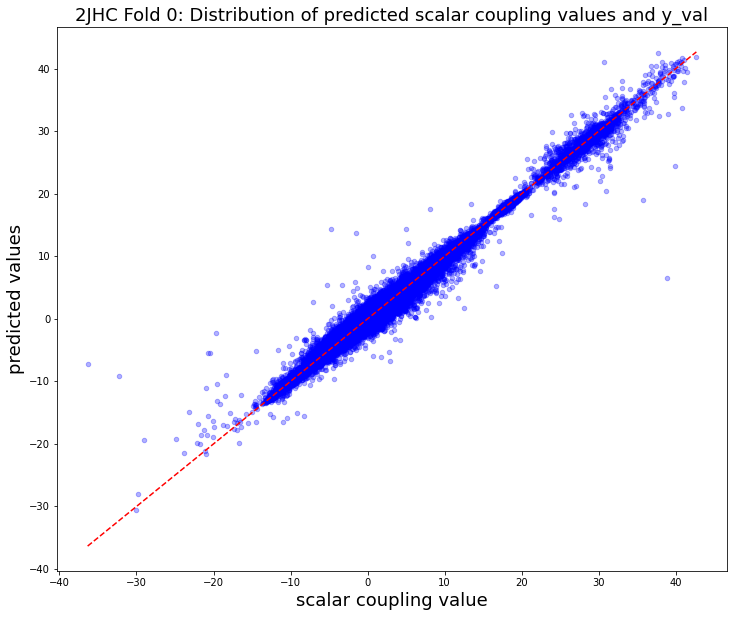

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.498854	valid_1's l1: 0.511486
[200]	training's l1: 0.423235	valid_1's l1: 0.444782
[300]	training's l1: 0.381968	valid_1's l1: 0.410452
[400]	training's l1: 0.354022	valid_1's l1: 0.388355
[500]	training's l1: 0.332587	valid_1's l1: 0.37206
[600]	training's l1: 0.315831	valid_1's l1: 0.359792
[700]	training's l1: 0.301513	valid_1's l1: 0.349764
[800]	training's l1: 0.289525	valid_1's l1: 0.341656
[900]	training's l1: 0.278898	valid_1's l1: 0.334814
[1000]	training's l1: 0.269517	valid_1's l1: 0.328641
[1100]	training's l1: 0.261172	valid_1's l1: 0.323494
[1200]	training's l1: 0.253638	valid_1's l1: 0.31908
[1300]	training's l1: 0.246545	valid_1's l1: 0.314992
[1400]	training's l1: 0.239832	valid_1's l1: 0.31116
[1500]	training's l1: 0.233747	valid_1's l1: 0.307739
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.233747	valid_1's l1: 0.307739
2JHC Fold 1, logMAE: -1.17850362762692

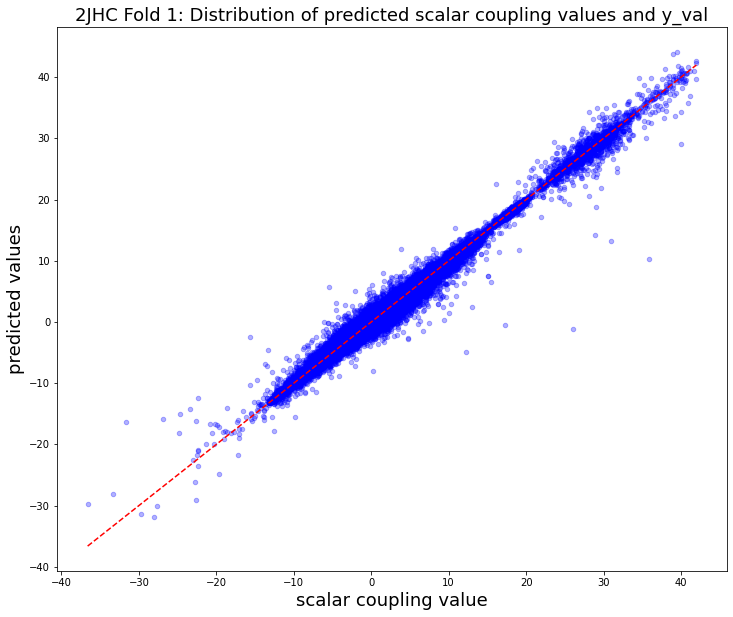

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.500674	valid_1's l1: 0.51432
[200]	training's l1: 0.422826	valid_1's l1: 0.444806
[300]	training's l1: 0.381763	valid_1's l1: 0.410132
[400]	training's l1: 0.354529	valid_1's l1: 0.388541
[500]	training's l1: 0.333313	valid_1's l1: 0.372373
[600]	training's l1: 0.31634	valid_1's l1: 0.360297
[700]	training's l1: 0.302406	valid_1's l1: 0.350578
[800]	training's l1: 0.290284	valid_1's l1: 0.342209
[900]	training's l1: 0.279671	valid_1's l1: 0.335224
[1000]	training's l1: 0.269982	valid_1's l1: 0.328884
[1100]	training's l1: 0.261311	valid_1's l1: 0.32357
[1200]	training's l1: 0.253409	valid_1's l1: 0.318766
[1300]	training's l1: 0.246342	valid_1's l1: 0.314509
[1400]	training's l1: 0.239894	valid_1's l1: 0.310749
[1500]	training's l1: 0.233833	valid_1's l1: 0.307336
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.233833	valid_1's l1: 0.307336
2JHC Fold 2, logMAE: -1.17981366531658

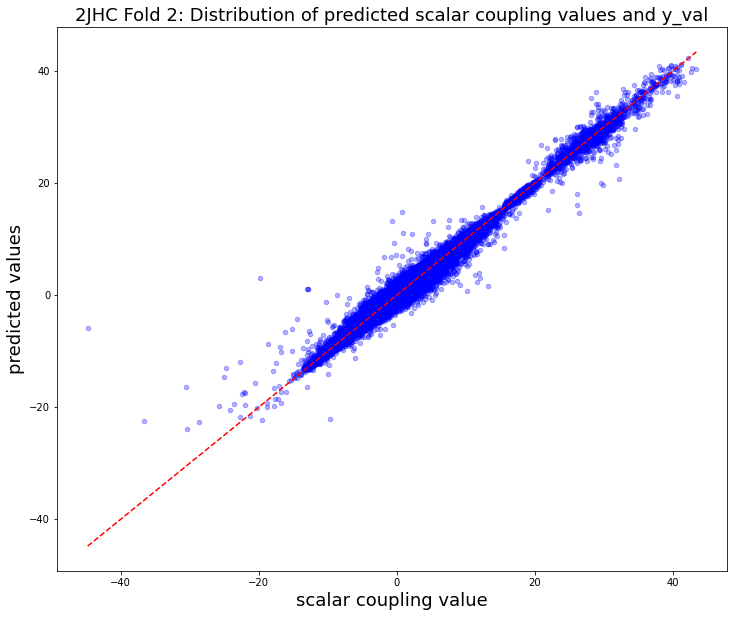

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.499891	valid_1's l1: 0.515509
[200]	training's l1: 0.424442	valid_1's l1: 0.447441
[300]	training's l1: 0.384284	valid_1's l1: 0.413799
[400]	training's l1: 0.356741	valid_1's l1: 0.391846
[500]	training's l1: 0.33495	valid_1's l1: 0.375346
[600]	training's l1: 0.317574	valid_1's l1: 0.362645
[700]	training's l1: 0.303385	valid_1's l1: 0.352711
[800]	training's l1: 0.291358	valid_1's l1: 0.344734
[900]	training's l1: 0.280971	valid_1's l1: 0.337924
[1000]	training's l1: 0.271537	valid_1's l1: 0.331911
[1100]	training's l1: 0.262731	valid_1's l1: 0.326317
[1200]	training's l1: 0.254909	valid_1's l1: 0.321611
[1300]	training's l1: 0.247536	valid_1's l1: 0.317136
[1400]	training's l1: 0.240955	valid_1's l1: 0.313349
[1500]	training's l1: 0.234917	valid_1's l1: 0.310003
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.234917	valid_1's l1: 0.310003
2JHC Fold 3, logMAE: -1.171174508123

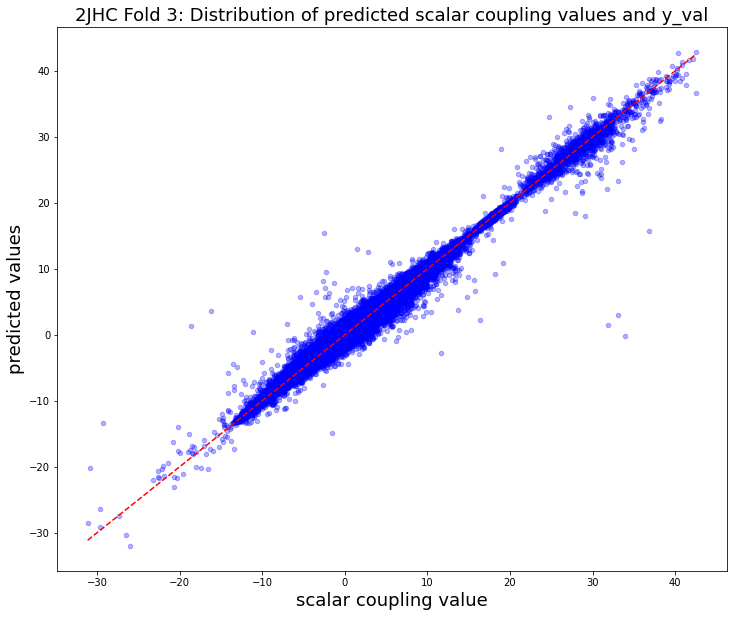

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.500099	valid_1's l1: 0.514665
[200]	training's l1: 0.42299	valid_1's l1: 0.445283
[300]	training's l1: 0.38265	valid_1's l1: 0.411504
[400]	training's l1: 0.354315	valid_1's l1: 0.389166
[500]	training's l1: 0.333377	valid_1's l1: 0.37301
[600]	training's l1: 0.31628	valid_1's l1: 0.360416
[700]	training's l1: 0.302164	valid_1's l1: 0.350337
[800]	training's l1: 0.289902	valid_1's l1: 0.341994
[900]	training's l1: 0.279238	valid_1's l1: 0.334885
[1000]	training's l1: 0.269809	valid_1's l1: 0.328915
[1100]	training's l1: 0.261477	valid_1's l1: 0.323704
[1200]	training's l1: 0.253782	valid_1's l1: 0.319115
[1300]	training's l1: 0.24666	valid_1's l1: 0.314833
[1400]	training's l1: 0.240162	valid_1's l1: 0.311088
[1500]	training's l1: 0.234203	valid_1's l1: 0.307728
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.234203	valid_1's l1: 0.307728
2JHC Fold 4, logMAE: -1.1785393369100563

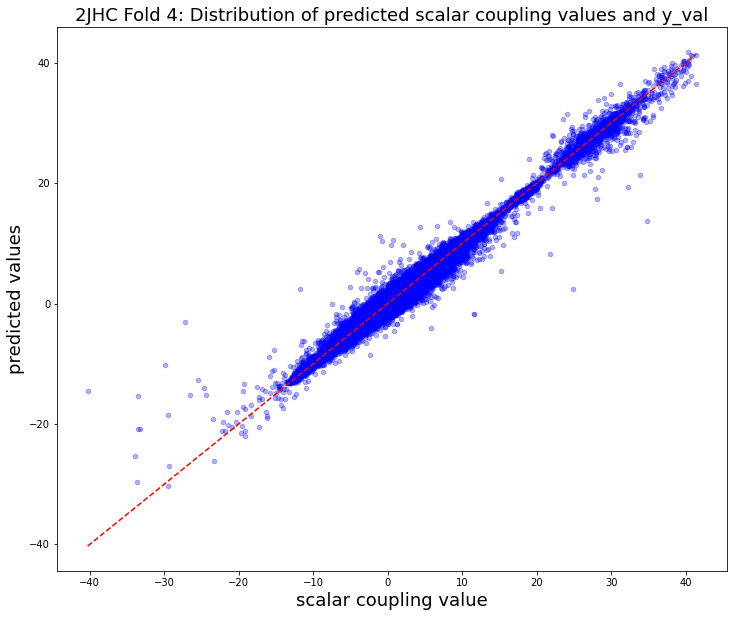

*** Training Model for 3JHH ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3', 'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0', 'd_4_1',
       'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0', 'd_6_1',
       'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0', 'd_8_1',
       'd_8_2', 'd_8_3'],
      dtype='object')
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.281737	valid_1's l1: 0.29552
[200]	training's l1: 0.231085	valid_1's l1: 0.252879
[300]	training's l1: 0.205956	valid_1's l1: 0.233

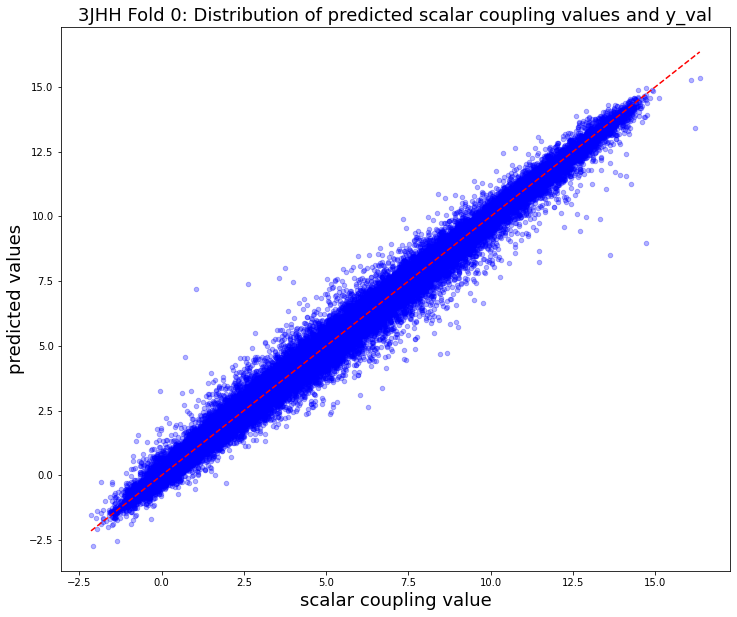

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.281015	valid_1's l1: 0.29507
[200]	training's l1: 0.230636	valid_1's l1: 0.252371
[300]	training's l1: 0.205222	valid_1's l1: 0.232798
[400]	training's l1: 0.187741	valid_1's l1: 0.220055
[500]	training's l1: 0.174038	valid_1's l1: 0.210592
[600]	training's l1: 0.163969	valid_1's l1: 0.204219
[700]	training's l1: 0.155147	valid_1's l1: 0.198937
[800]	training's l1: 0.147547	valid_1's l1: 0.194462
[900]	training's l1: 0.141056	valid_1's l1: 0.190874
[1000]	training's l1: 0.135209	valid_1's l1: 0.18779
[1100]	training's l1: 0.130093	valid_1's l1: 0.185148
[1200]	training's l1: 0.125207	valid_1's l1: 0.182691
[1300]	training's l1: 0.120607	valid_1's l1: 0.180435
[1400]	training's l1: 0.116532	valid_1's l1: 0.178531
[1500]	training's l1: 0.112807	valid_1's l1: 0.176807
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.112807	valid_1's l1: 0.176807
3JHH Fold 1, logMAE: -1.7326969777018

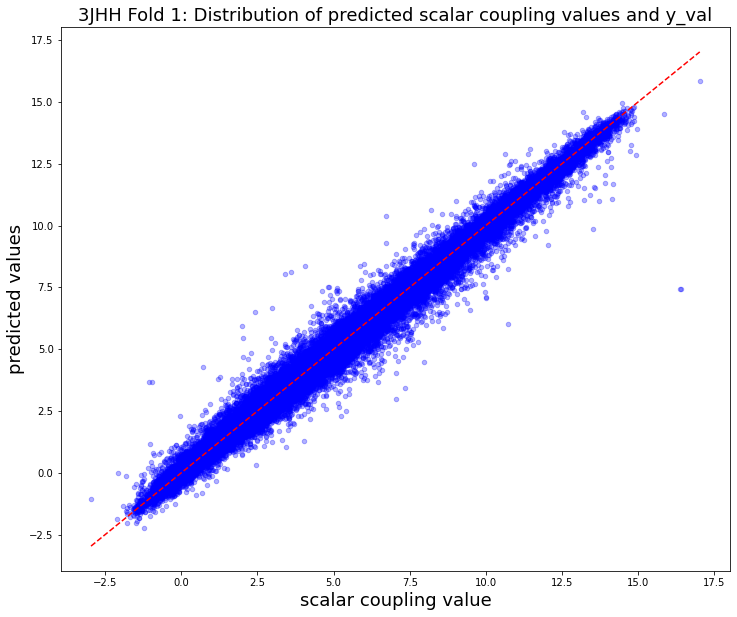

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.280712	valid_1's l1: 0.293791
[200]	training's l1: 0.231183	valid_1's l1: 0.251736
[300]	training's l1: 0.205388	valid_1's l1: 0.231904
[400]	training's l1: 0.188006	valid_1's l1: 0.219649
[500]	training's l1: 0.175026	valid_1's l1: 0.210928
[600]	training's l1: 0.164223	valid_1's l1: 0.203961
[700]	training's l1: 0.155431	valid_1's l1: 0.198564
[800]	training's l1: 0.147978	valid_1's l1: 0.194344
[900]	training's l1: 0.141367	valid_1's l1: 0.190689
[1000]	training's l1: 0.135447	valid_1's l1: 0.187505
[1100]	training's l1: 0.130204	valid_1's l1: 0.184802
[1200]	training's l1: 0.12535	valid_1's l1: 0.182223
[1300]	training's l1: 0.120875	valid_1's l1: 0.180078
[1400]	training's l1: 0.116781	valid_1's l1: 0.17821
[1500]	training's l1: 0.113054	valid_1's l1: 0.176561
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.113054	valid_1's l1: 0.176561
3JHH Fold 2, logMAE: -1.7340866020022

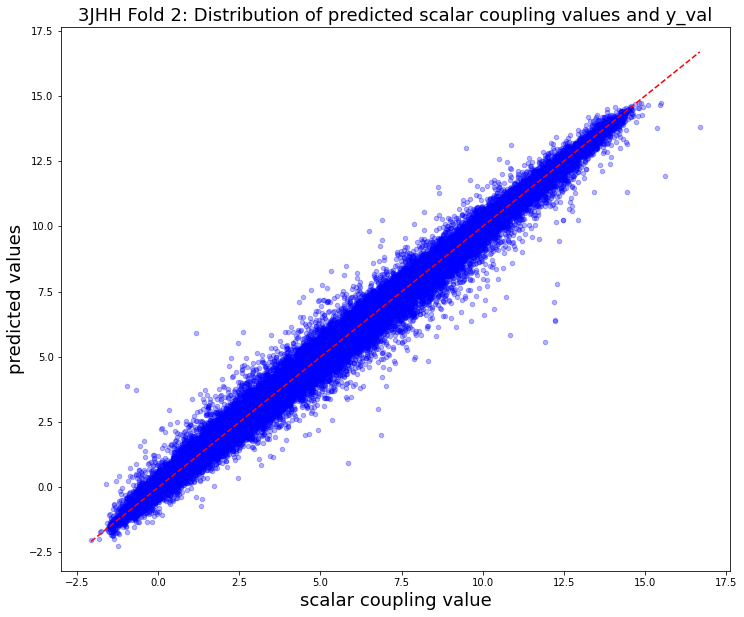

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.280086	valid_1's l1: 0.293595
[200]	training's l1: 0.231854	valid_1's l1: 0.252406
[300]	training's l1: 0.205943	valid_1's l1: 0.232054
[400]	training's l1: 0.188337	valid_1's l1: 0.219486
[500]	training's l1: 0.175527	valid_1's l1: 0.21081
[600]	training's l1: 0.164839	valid_1's l1: 0.20394
[700]	training's l1: 0.156091	valid_1's l1: 0.198659
[800]	training's l1: 0.148461	valid_1's l1: 0.194139
[900]	training's l1: 0.141675	valid_1's l1: 0.190462
[1000]	training's l1: 0.135735	valid_1's l1: 0.187247
[1100]	training's l1: 0.13047	valid_1's l1: 0.184568
[1200]	training's l1: 0.125632	valid_1's l1: 0.182035
[1300]	training's l1: 0.1211	valid_1's l1: 0.179769
[1400]	training's l1: 0.117103	valid_1's l1: 0.177916
[1500]	training's l1: 0.113266	valid_1's l1: 0.176166
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.113266	valid_1's l1: 0.176166
3JHH Fold 3, logMAE: -1.7363310827289864

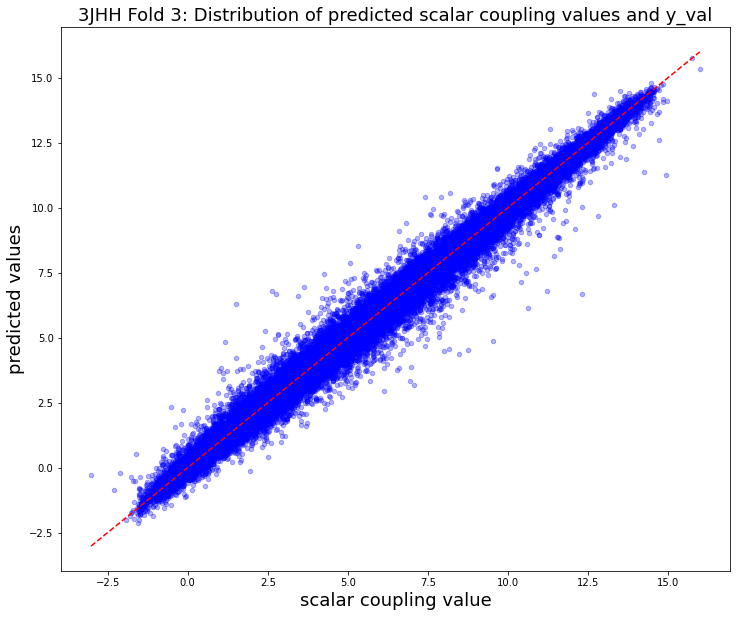

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.283854	valid_1's l1: 0.297302
[200]	training's l1: 0.233009	valid_1's l1: 0.253384
[300]	training's l1: 0.20707	valid_1's l1: 0.233632
[400]	training's l1: 0.189269	valid_1's l1: 0.220569
[500]	training's l1: 0.175992	valid_1's l1: 0.211616
[600]	training's l1: 0.165249	valid_1's l1: 0.204534
[700]	training's l1: 0.156223	valid_1's l1: 0.199035
[800]	training's l1: 0.148577	valid_1's l1: 0.194571
[900]	training's l1: 0.141949	valid_1's l1: 0.190892
[1000]	training's l1: 0.135873	valid_1's l1: 0.187679
[1100]	training's l1: 0.130531	valid_1's l1: 0.184959
[1200]	training's l1: 0.125675	valid_1's l1: 0.182479
[1300]	training's l1: 0.121181	valid_1's l1: 0.180407
[1400]	training's l1: 0.117019	valid_1's l1: 0.178423
[1500]	training's l1: 0.113234	valid_1's l1: 0.176691
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.113234	valid_1's l1: 0.176691
3JHH Fold 4, logMAE: -1.733352671664

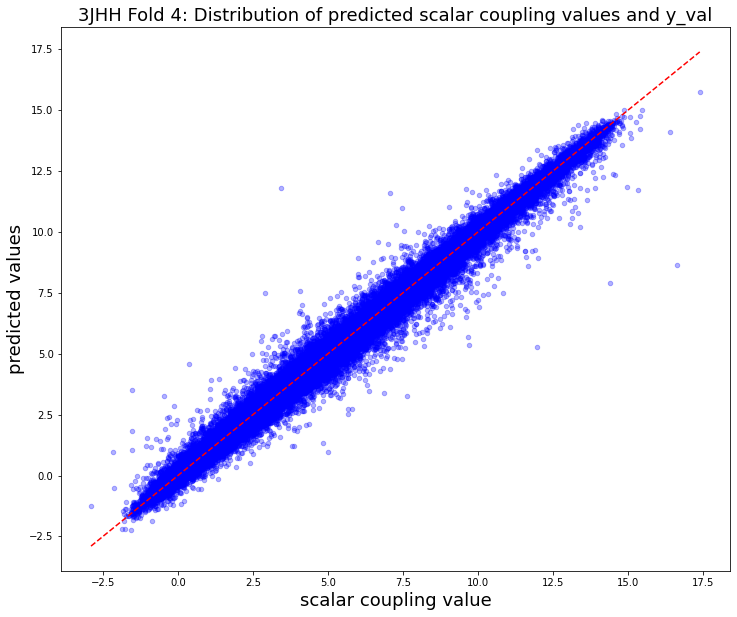

*** Training Model for 3JHC ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0',
       'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0',
       'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0',
       'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3',
       'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0',
       'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0',
       'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0',
       'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3'],
      dtype='object')
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.555638	valid_1's l1: 0.566968
[2

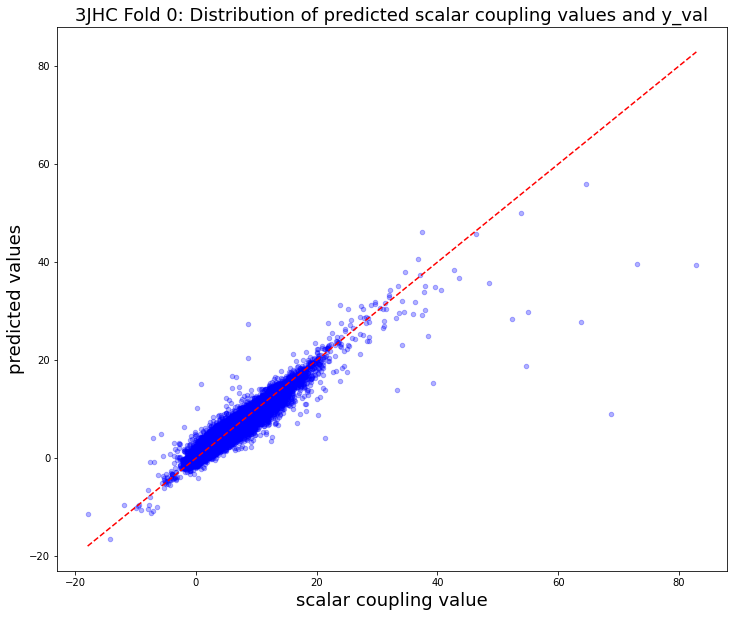

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.553456	valid_1's l1: 0.564849
[200]	training's l1: 0.472158	valid_1's l1: 0.490282
[300]	training's l1: 0.429879	valid_1's l1: 0.453687
[400]	training's l1: 0.401451	valid_1's l1: 0.430068
[500]	training's l1: 0.379279	valid_1's l1: 0.412308
[600]	training's l1: 0.361974	valid_1's l1: 0.398943
[700]	training's l1: 0.347029	valid_1's l1: 0.387699
[800]	training's l1: 0.334566	valid_1's l1: 0.378807
[900]	training's l1: 0.323516	valid_1's l1: 0.371215
[1000]	training's l1: 0.313418	valid_1's l1: 0.364393
[1100]	training's l1: 0.304397	valid_1's l1: 0.358455
[1200]	training's l1: 0.296251	valid_1's l1: 0.353245
[1300]	training's l1: 0.288674	valid_1's l1: 0.348434
[1400]	training's l1: 0.281725	valid_1's l1: 0.344201
[1500]	training's l1: 0.275237	valid_1's l1: 0.34033
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.275237	valid_1's l1: 0.34033
3JHC Fold 1, logMAE: -1.0778406170558

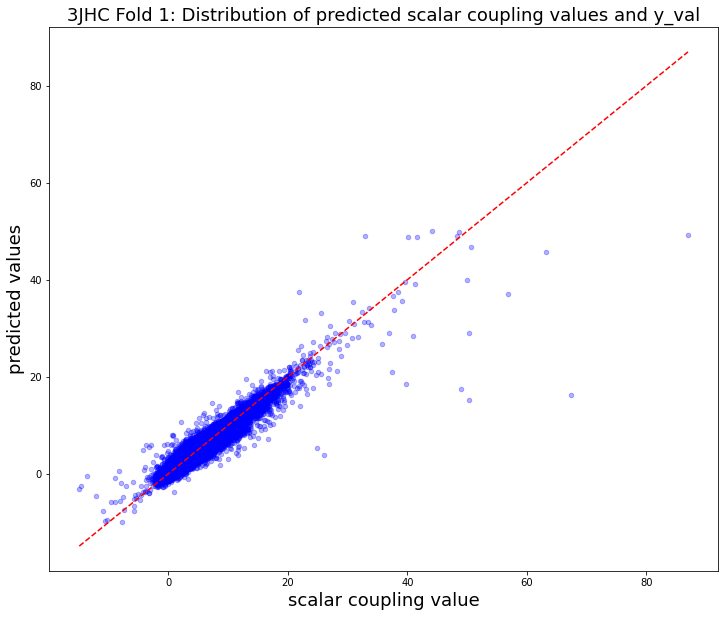

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.555942	valid_1's l1: 0.567315
[200]	training's l1: 0.473621	valid_1's l1: 0.491271
[300]	training's l1: 0.43066	valid_1's l1: 0.454248
[400]	training's l1: 0.401622	valid_1's l1: 0.430158
[500]	training's l1: 0.380152	valid_1's l1: 0.413176
[600]	training's l1: 0.362337	valid_1's l1: 0.399501
[700]	training's l1: 0.347225	valid_1's l1: 0.38819
[800]	training's l1: 0.33446	valid_1's l1: 0.379093
[900]	training's l1: 0.32324	valid_1's l1: 0.371314
[1000]	training's l1: 0.313161	valid_1's l1: 0.36448
[1100]	training's l1: 0.304215	valid_1's l1: 0.358581
[1200]	training's l1: 0.296155	valid_1's l1: 0.353303
[1300]	training's l1: 0.288619	valid_1's l1: 0.348653
[1400]	training's l1: 0.281874	valid_1's l1: 0.344598
[1500]	training's l1: 0.275328	valid_1's l1: 0.340645
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.275328	valid_1's l1: 0.340645
3JHC Fold 2, logMAE: -1.0769134877038287

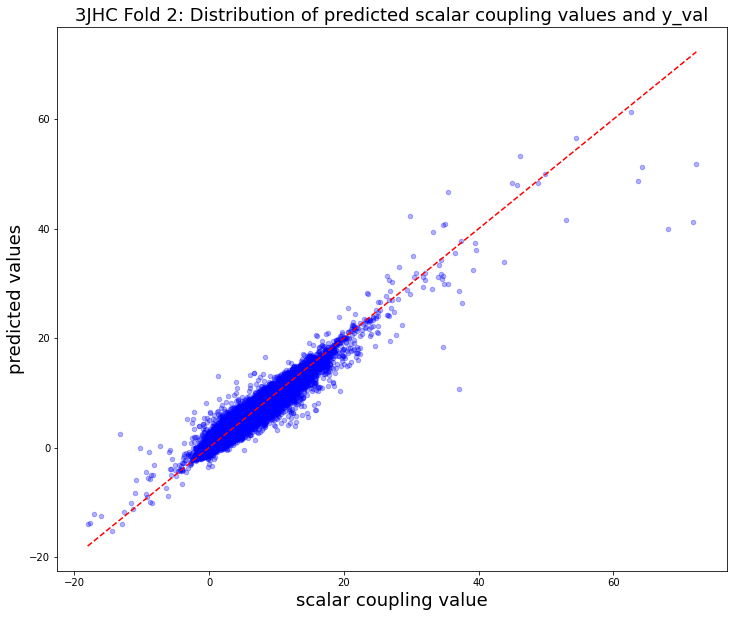

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.553213	valid_1's l1: 0.563926
[200]	training's l1: 0.472289	valid_1's l1: 0.490471
[300]	training's l1: 0.429579	valid_1's l1: 0.453733
[400]	training's l1: 0.40042	valid_1's l1: 0.429659
[500]	training's l1: 0.378429	valid_1's l1: 0.412384
[600]	training's l1: 0.360751	valid_1's l1: 0.398831
[700]	training's l1: 0.345648	valid_1's l1: 0.387611
[800]	training's l1: 0.332847	valid_1's l1: 0.378319
[900]	training's l1: 0.321655	valid_1's l1: 0.370285
[1000]	training's l1: 0.311893	valid_1's l1: 0.3637
[1100]	training's l1: 0.303159	valid_1's l1: 0.357983
[1200]	training's l1: 0.295131	valid_1's l1: 0.352784
[1300]	training's l1: 0.287642	valid_1's l1: 0.348159
[1400]	training's l1: 0.280788	valid_1's l1: 0.344025
[1500]	training's l1: 0.274554	valid_1's l1: 0.340267
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.274554	valid_1's l1: 0.340267
3JHC Fold 3, logMAE: -1.07802529798576

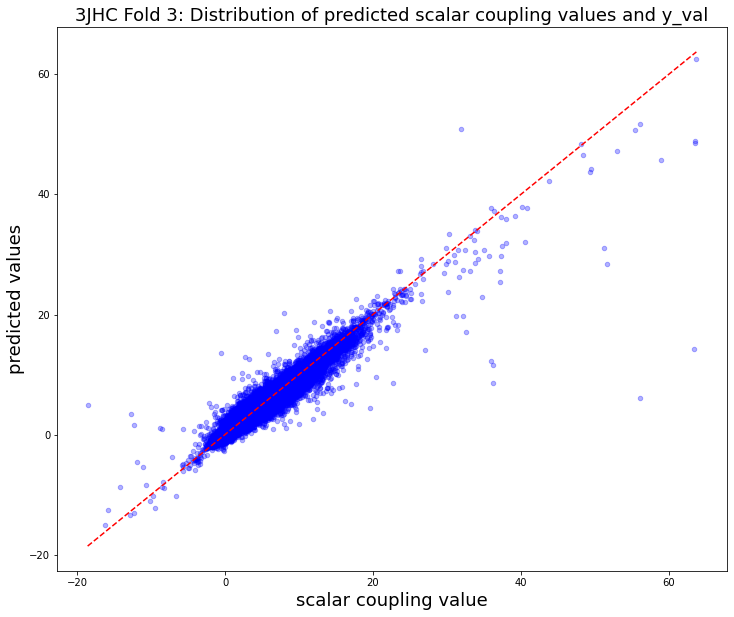

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.551728	valid_1's l1: 0.561957
[200]	training's l1: 0.472379	valid_1's l1: 0.490547
[300]	training's l1: 0.429351	valid_1's l1: 0.453474
[400]	training's l1: 0.400219	valid_1's l1: 0.429386
[500]	training's l1: 0.37848	valid_1's l1: 0.412368
[600]	training's l1: 0.360877	valid_1's l1: 0.398937
[700]	training's l1: 0.34605	valid_1's l1: 0.38775
[800]	training's l1: 0.333684	valid_1's l1: 0.379028
[900]	training's l1: 0.322388	valid_1's l1: 0.371154
[1000]	training's l1: 0.312413	valid_1's l1: 0.364363
[1100]	training's l1: 0.303596	valid_1's l1: 0.358658
[1200]	training's l1: 0.295573	valid_1's l1: 0.353571
[1300]	training's l1: 0.288235	valid_1's l1: 0.348923
[1400]	training's l1: 0.281426	valid_1's l1: 0.344819
[1500]	training's l1: 0.275093	valid_1's l1: 0.341199
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.275093	valid_1's l1: 0.341199
3JHC Fold 4, logMAE: -1.07528838377022

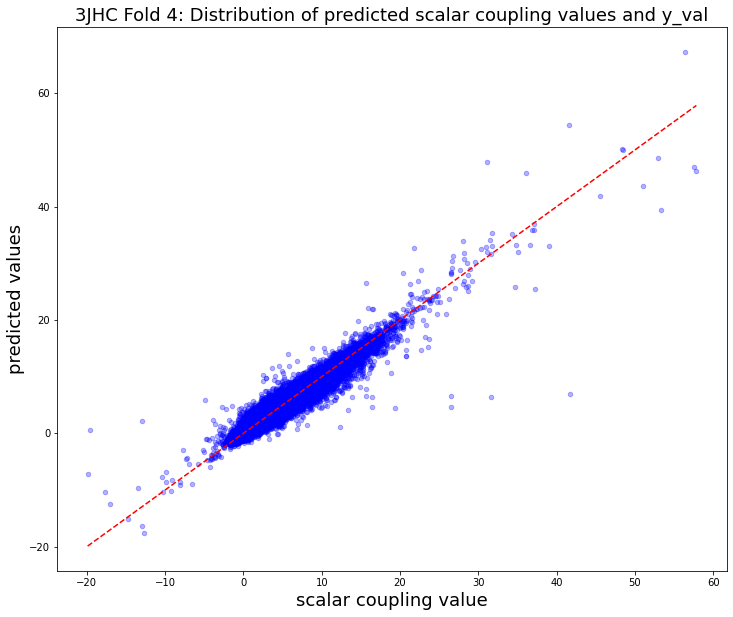

*** Training Model for 3JHN ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0',
       'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0',
       'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0',
       'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3',
       'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'atom_9', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1', 'd_3_2', 'd_4_0',
       'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2', 'd_5_3', 'd_6_0',
       'd_6_1', 'd_6_2', 'd_6_3', 'd_7_0', 'd_7_1', 'd_7_2', 'd_7_3', 'd_8_0',
       'd_8_1', 'd_8_2', 'd_8_3', 'd_9_0', 'd_9_1', 'd_9_2', 'd_9_3'],
      dtype='object')
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.150201	valid_1's l1: 0.170565
[2

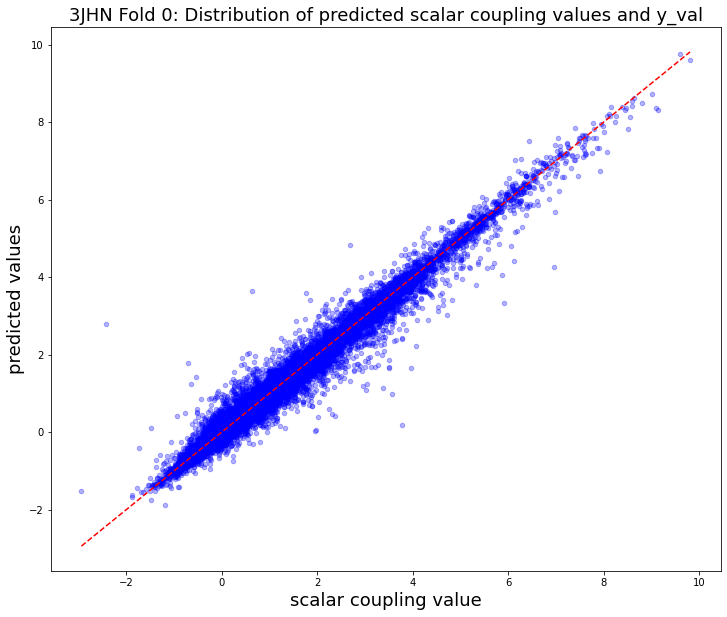

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.150832	valid_1's l1: 0.171091
[200]	training's l1: 0.121674	valid_1's l1: 0.15072
[300]	training's l1: 0.104706	valid_1's l1: 0.140147
[400]	training's l1: 0.0927696	valid_1's l1: 0.133685
[500]	training's l1: 0.0841905	valid_1's l1: 0.129553
[600]	training's l1: 0.0769059	valid_1's l1: 0.126114
[700]	training's l1: 0.0707478	valid_1's l1: 0.123407
[800]	training's l1: 0.0654823	valid_1's l1: 0.121297
[900]	training's l1: 0.061108	valid_1's l1: 0.119613
[1000]	training's l1: 0.057037	valid_1's l1: 0.118123
[1100]	training's l1: 0.0534202	valid_1's l1: 0.116804
[1200]	training's l1: 0.0503583	valid_1's l1: 0.115745
[1300]	training's l1: 0.0475825	valid_1's l1: 0.114889
[1400]	training's l1: 0.0449555	valid_1's l1: 0.114059
[1500]	training's l1: 0.042622	valid_1's l1: 0.113317
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.042622	valid_1's l1: 0.113317
3JHN Fold 1, logMAE: -2.177

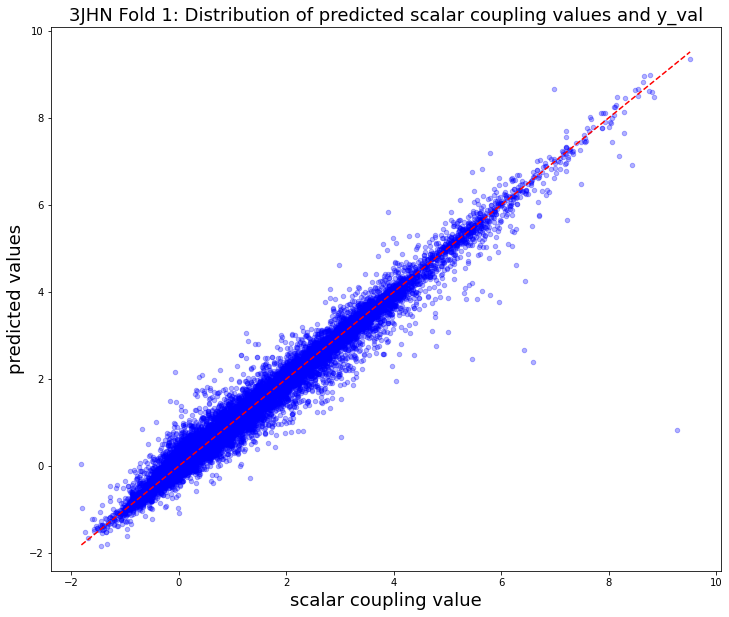

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.150436	valid_1's l1: 0.172393
[200]	training's l1: 0.119985	valid_1's l1: 0.150834
[300]	training's l1: 0.104102	valid_1's l1: 0.141357
[400]	training's l1: 0.0920972	valid_1's l1: 0.134923
[500]	training's l1: 0.0834709	valid_1's l1: 0.130765
[600]	training's l1: 0.0762501	valid_1's l1: 0.127547
[700]	training's l1: 0.0703897	valid_1's l1: 0.125057
[800]	training's l1: 0.0651711	valid_1's l1: 0.122877
[900]	training's l1: 0.0606513	valid_1's l1: 0.121166
[1000]	training's l1: 0.0568746	valid_1's l1: 0.119793
[1100]	training's l1: 0.0534494	valid_1's l1: 0.118519
[1200]	training's l1: 0.0503043	valid_1's l1: 0.117407
[1300]	training's l1: 0.0474192	valid_1's l1: 0.116497
[1400]	training's l1: 0.0448879	valid_1's l1: 0.115707
[1500]	training's l1: 0.0425316	valid_1's l1: 0.114961
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0425316	valid_1's l1: 0.114961
3JHN Fold 2, logMAE: -

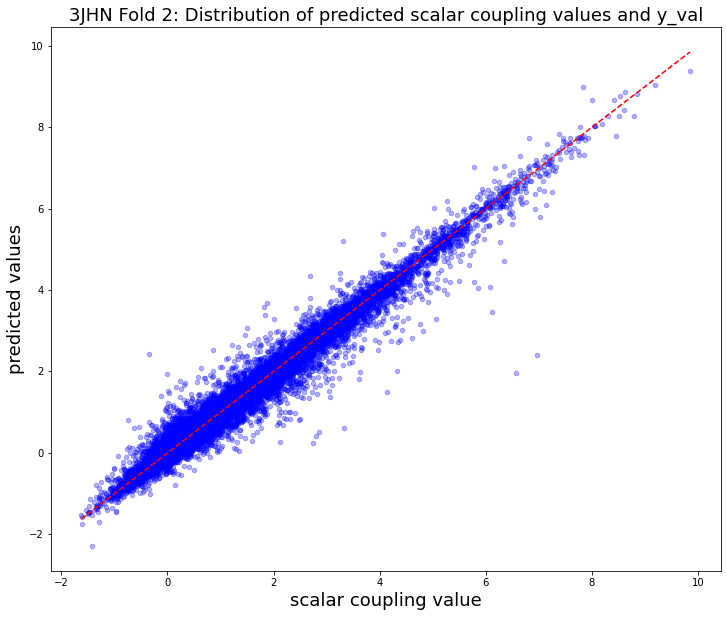

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.149945	valid_1's l1: 0.172826
[200]	training's l1: 0.119299	valid_1's l1: 0.151178
[300]	training's l1: 0.103244	valid_1's l1: 0.140888
[400]	training's l1: 0.0923101	valid_1's l1: 0.135231
[500]	training's l1: 0.0831799	valid_1's l1: 0.130664
[600]	training's l1: 0.0763524	valid_1's l1: 0.127437
[700]	training's l1: 0.0703432	valid_1's l1: 0.124862
[800]	training's l1: 0.0652692	valid_1's l1: 0.123034
[900]	training's l1: 0.0608427	valid_1's l1: 0.121306
[1000]	training's l1: 0.0569285	valid_1's l1: 0.119914
[1100]	training's l1: 0.0533906	valid_1's l1: 0.118705
[1200]	training's l1: 0.050366	valid_1's l1: 0.117719
[1300]	training's l1: 0.0474721	valid_1's l1: 0.116903
[1400]	training's l1: 0.0448606	valid_1's l1: 0.116147
[1500]	training's l1: 0.0425006	valid_1's l1: 0.115449
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0425006	valid_1's l1: 0.115449
3JHN Fold 3, logMAE: -2

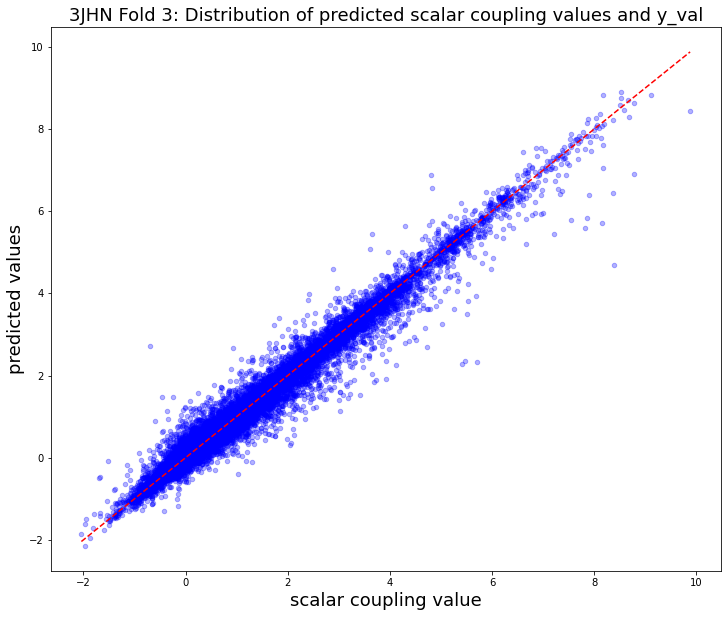

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.148847	valid_1's l1: 0.172568
[200]	training's l1: 0.119555	valid_1's l1: 0.151605
[300]	training's l1: 0.103031	valid_1's l1: 0.141429
[400]	training's l1: 0.0916211	valid_1's l1: 0.135198
[500]	training's l1: 0.0832465	valid_1's l1: 0.13096
[600]	training's l1: 0.0760982	valid_1's l1: 0.127733
[700]	training's l1: 0.0704016	valid_1's l1: 0.125423
[800]	training's l1: 0.0652307	valid_1's l1: 0.123325
[900]	training's l1: 0.0609947	valid_1's l1: 0.121678
[1000]	training's l1: 0.056892	valid_1's l1: 0.120172
[1100]	training's l1: 0.0533698	valid_1's l1: 0.118894
[1200]	training's l1: 0.0503184	valid_1's l1: 0.117888
[1300]	training's l1: 0.0475734	valid_1's l1: 0.116987
[1400]	training's l1: 0.0449573	valid_1's l1: 0.116207
[1500]	training's l1: 0.0425392	valid_1's l1: 0.115401
Did not meet early stopping. Best iteration is:
[1500]	training's l1: 0.0425392	valid_1's l1: 0.115401
3JHN Fold 4, logMAE: -2.

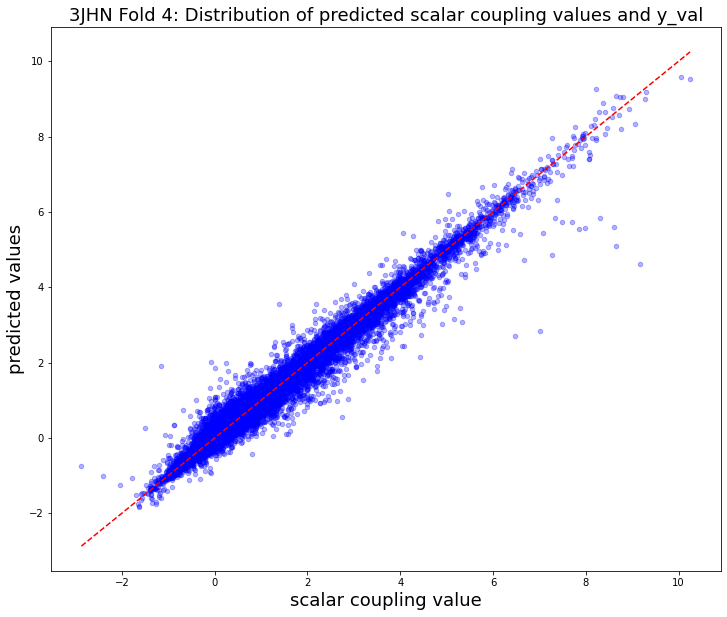

Finished running successfully
CPU times: user 7h 9min 19s, sys: 2min 49s, total: 7h 12min 8s
Wall time: 1h 56min 56s


In [265]:
%%time

model_params = {
    '1JHN': 7,
    '1JHC': 10,
    '2JHH': 9,
    '2JHN': 9,
    '2JHC': 9,
    '3JHH': 9,
    '3JHC': 10,
    '3JHN': 10
}
N_FOLDS = 5
output_result = output_result_csv.copy()
# https://beginnersbook.com/2019/03/python-set-copy-method/

cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_for_one_coupling_type(
        coupling_type, output_result, n_atoms=model_params[coupling_type], n_folds=N_FOLDS)
    cv_scores[coupling_type] = cv_score
print("Finished running successfully")

Checking cross-validation scores for each type:

In [266]:
pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score ( ln )': list(cv_scores.values())})

type  cv_score ( ln )
0  1JHN -0.953780       
1  1JHC -0.250498       
2  2JHH -1.715251       
3  2JHN -1.917860       
4  2JHC -1.176226       
5  3JHH -1.733693       
6  3JHC -1.077194       
7  3JHN -2.167427

In [267]:
import math

pd.DataFrame({'type': list(cv_scores.keys()), 'mean_absolute_error': [ math.exp(el) for el in list(cv_scores.values())]})

type  mean_absolute_error
0  1JHN  0.385282           
1  1JHC  0.778413           
2  2JHH  0.179919           
3  2JHN  0.146921           
4  2JHC  0.308441           
5  3JHH  0.176631           
6  3JHC  0.340550           
7  3JHN  0.114472

## Room for improvement


* Tune LGB hyperparameters
* Tune number of atoms for each type
* Try to add other features
* Play with categorical features for atom types (one-hot-encoding, CatBoost?)
* Try other tree libraries
* Consider angles among bonds
* Include more surrounding atoms
